### Pair Correlation for ICM Organoids

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from scipy.spatial.distance import cdist
from Functions import *

C = pd.read_csv('Data/includingSurfaceDistance/extendedRawDataICMOrganoids.csv')
    
def paircorrelation(Population, Type, GraphDist):
    x = np.zeros(len(Population))
    x[(Population == Type)] = 1
    maxdist = int(np.max(GraphDist))
    ind = np.where(x==1)[0]
    if ind.size == 0:
        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = 0
            
    else:
        dist = GraphDist[ind].T[ind].T
        rho0 = sum(x)/len(x)
        rho1 = (sum(x)-1)/(len(x)-1)


        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = len(dist[dist==i])/len(GraphDist[GraphDist==i])/rho0/rho1

    return P


def correlation_correction(Population, Type, GraphDist):
    x = np.zeros(len(Population))
    y = np.zeros(len(Population))
    x[(Population == Type)] = 1
    y[(Population == 'N+G+') | (Population == 'N-G-')] = 1
    maxdist = int(np.max(GraphDist))
    ind = np.where(x==1)[0]
    cor_ind = np.where(y==1)[0]
    if ind.size == 0:
        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = 0
            
    else:
        equals = GraphDist[ind].T[ind].T
        mixed = GraphDist[cor_ind].T[ind].T
        none =  GraphDist[cor_ind].T[cor_ind].T
        
        rho_equals = sum(x)*(sum(x)-1)/len(x)/(len(x)-1)
        rho_mixed = sum(x)*sum(y)/len(x)/(len(x)-1)
        rho_none = sum(y)*(sum(y)-1)/len(x)/(len(x)-1)
        
        rho_total = (sum(x) + sum(y)/2)*(sum(x)-1 + sum(y)/2)/len(x)/(len(x)-1)

        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = (len(equals[equals==i])/len(GraphDist[GraphDist==i])/rho_total \
                   + len(mixed[mixed==i])/len(GraphDist[GraphDist==i])/rho_total \
                   + 0.25*len(none[none==i])/len(GraphDist[GraphDist==i])/rho_total)

    return P


N = []
G = []
N_cor = []
G_cor = []
DN = []
DP = []
nofCells = []
Stage = []
N_mean = 0
G_mean = 0
DN_mean = 0
DP_mean = 0
number = 0
for K in range(max(C['OrganoidID'])):
    Organoids = max(C['OrganoidID'])
    ID = K+1
    Cindex = []
    Cells = []

    for i in range(len(C)):
        if C['OrganoidID'][i] == ID:
            Cindex.append(i)

    x = np.array(C.loc[Cindex,'CentroidX'])
    y = np.array(C.loc[Cindex,'CentroidY'])
    z = np.array(C.loc[Cindex,'CentroidZ'])
    Nanog = np.array(C.loc[Cindex,'Nanog-Avg'])
    Gata6 = np.array(C.loc[Cindex,'Gata6-Avg'])
    Population = np.array(C.loc[Cindex,'Population'])
    stage = np.array(C.loc[Cindex,'stage'])
    
    nofN = len(Population[Population == 'N+G-'])
    nofG = len(Population[Population == 'N-G+'])
    nofDP = len(Population[Population == 'N+G+'])
    nofDN = len(Population[Population == 'N-G-'])
    
    #if nofDN/len(x) + nofDP/len(x) > 0.25 or stage[0]=='24h' or nofN/nofG < 2 or nofG/nofN < 2:
    #if stage[0]=='24h':
    #if nofG == 0:
    #    nofG = 1e-8
    #if nofN == 0:
    #    nofN = 1e-8
        
    if (nofDN/len(x) + nofDP/len(x) > 0.25 or stage[0]=='24h' or nofN/nofG > 2 or nofG/nofN > 2):
        continue

    #N_mean += nofN/len(x)
    #G_mean += nofG/len(x)
    #DN_mean += nofDN/len(x)
    #DP_mean += nofDP/len(x)
    #number += 1
        
    print('Organoid', ID, 'consists of', len(Cindex), 'cells')

    pos = np.empty([len(x), 3])
    pos[:,0] = x
    pos[:,1] = y
    pos[:,2] = z

    GraphDist = graphdistance3D(pos, cutoff=91)
    
    #Population[Nanog > Gata6] = 'N+G-'
    #Population[Nanog <= Gata6] = 'N-G+'
    N.append(paircorrelation(Population, 'N+G-', GraphDist))
    G.append(paircorrelation(Population, 'N-G+', GraphDist))
    N_cor.append(correlation_correction(Population, 'N+G-', GraphDist))
    G_cor.append(correlation_correction(Population, 'N-G+', GraphDist))
    DN.append(paircorrelation(Population, 'N-G-', GraphDist))
    DP.append(paircorrelation(Population, 'N+G+',GraphDist))
    Stage.append(stage[0])
    nofCells.append(len(x))
    
print('Finished!')

Organoid 14 consists of 1531 cells
Organoid 15 consists of 1474 cells
Organoid 39 consists of 935 cells
Organoid 47 consists of 962 cells
Organoid 50 consists of 812 cells
Organoid 51 consists of 955 cells
Organoid 52 consists of 984 cells
Organoid 53 consists of 751 cells
Organoid 54 consists of 663 cells
Organoid 62 consists of 1051 cells
Finished!


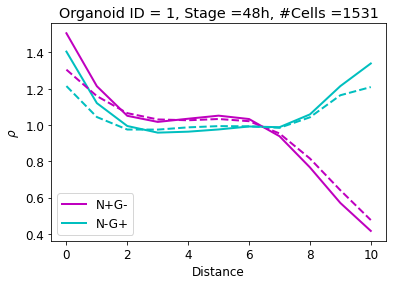

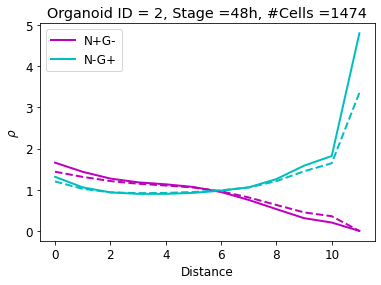

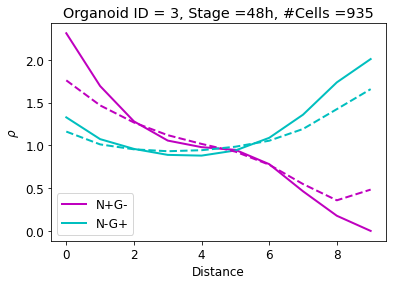

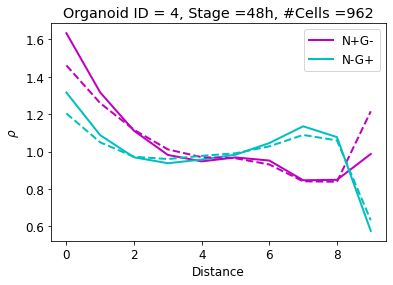

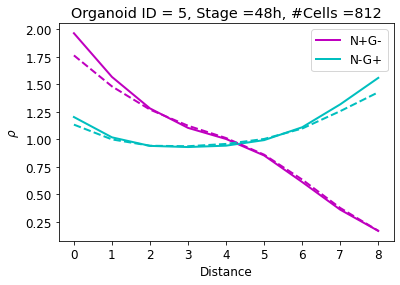

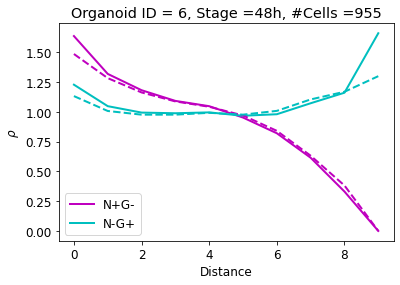

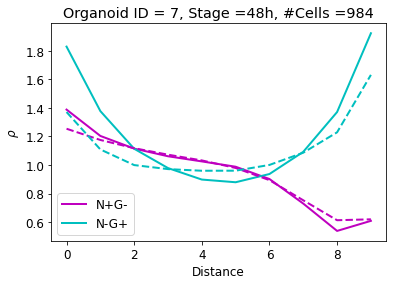

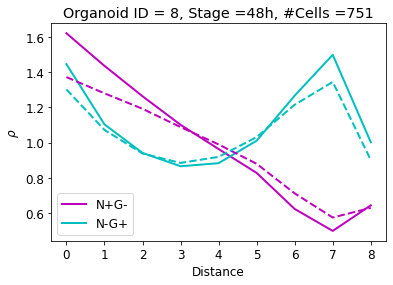

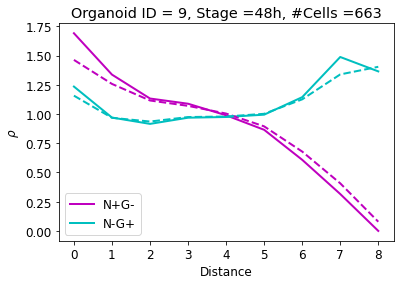

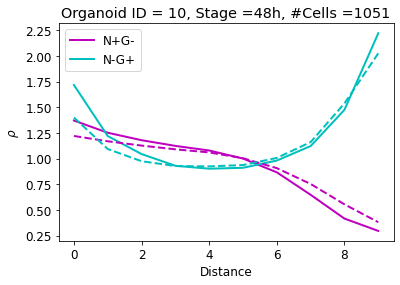

In [17]:
for i in range(len(N)):
    plt.figure()
    plt.rc('font', size=12)
    plt.plot(N[i], 'm', lw=2, label = 'N+G-')
    plt.plot(G[i], 'c', lw=2, label = 'N-G+')
    plt.plot(N_cor[i], 'm--', lw=2)
    plt.plot(G_cor[i], 'c--', lw=2)
    #plt.plot(DP[i], 'k--', alpha = 0.5, lw=2, label = 'N+G+')
    #plt.plot(DN[i], 'k', ls='dotted', alpha = 0.5, lw=2, label = 'N-G-')
    plt.title('Organoid ID = '+str(i+1)+ ', Stage ='+str(Stage[i])+', #Cells ='+str(nofCells[i]))
    plt.xlabel('Distance')
    plt.ylabel('$\\rho$')
    plt.legend()
    #plt.savefig('Results/Pair Correlations (without DN DP)/ID='+str(i+1)+'.png')

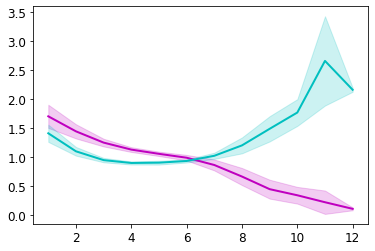

In [3]:
maxdist = 0
for i in range(len(N)):
    if maxdist < len(N[i]):
        maxdist = len(N[i])

amount = np.zeros(maxdist)
N_mean = np.zeros(maxdist)
G_mean = np.zeros(maxdist)
N_std = np.zeros(maxdist)
G_std = np.zeros(maxdist)
DN_mean = np.zeros(maxdist)
DP_mean = np.zeros(maxdist)
DN_std = np.zeros(maxdist)
DP_std = np.zeros(maxdist)
x = list(range(1,maxdist+1))
for i in range(len(N)):
    for j in range(len(N[i])):
        N_mean[j] += N[i][j]
        G_mean[j] += G[i][j]
        DN_mean[j] += DN[i][j]
        DP_mean[j] += DP[i][j]
        amount[j] += 1
        
N_mean = N_mean/amount
G_mean = G_mean/amount


for i in range(len(N)):
    for j in range(len(N[i])):
        N_std[j] += (N[i][j]-N_mean[j])**2
        G_std[j] += (G[i][j]-G_mean[j])**2
        DN_std[j] += (DN[i][j]-DN_mean[j])**2
        DP_std[j] += (DP[i][j]-DP_mean[j])**2
        amount[j] += 1

N_std = (N_std/amount)**(1/2)
G_std = (G_std/amount)**(1/2)
DN_std = (DN_std/amount)**(1/2)
DP_std = (DP_std/amount)**(1/2)
        
plt.plot(x, N_mean, 'm', lw = 2)
plt.plot(x, G_mean, 'c', lw = 2)
#plt.plot(x, DN_mean, 'k', lw = 2)
#plt.plot(x, DP_mean, 'b', lw = 2)
plt.fill_between(x, N_mean - N_std, N_mean + N_std, color='m', alpha = 0.2)
plt.fill_between(x, G_mean - G_std, G_mean + G_std, color='c', alpha = 0.2)
#plt.fill_between(x, DN_mean - DN_std, DN_mean + DN_std, color='k', alpha = 0.2)
#plt.fill_between(x, DP_mean - DP_std, DP_mean + DP_std, color='b', alpha = 0.2)

<br>
<br>
<br>

### Pair correlation for non-local model data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from FVmesh import initializeFVmesh
from Organoid2D import initializeOrganoid
from Functions import loadData, fate
import networkx as nx

N = np.empty([9,177])
G = np.empty([9,177])

Pos, Radius, N[0,:], G[0,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=1_10/Data.csv')
Pos, Radius, N[1,:], G[1,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=2_10/Data.csv')
Pos, Radius, N[2,:], G[2,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=3_10/Data.csv')
Pos, Radius, N[3,:], G[3,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=4_10/Data.csv')
Pos, Radius, N[4,:], G[4,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=5_10/Data.csv')
Pos, Radius, N[5,:], G[5,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=6_10/Data.csv')
Pos, Radius, N[6,:], G[6,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=7_10/Data.csv')
Pos, Radius, N[7,:], G[7,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=8_10/Data.csv')
Pos, Radius, N[8,:], G[8,:] = loadData('Results/Publications/Pattern Formation/Cell Fate - q=9_10/Data.csv')

FVmesh = initializeFVmesh(Pos, Radius=Radius)
Gr = nx.Graph()
for path in FVmesh.Tri.simplices:

    path1 = [path[0], path[1]]
    path2 = [path[1], path[2]]
    path3 = [path[2], path[0]]

    if FVmesh.Dist[path1[0],path1[1]] < 2.2:
        nx.add_path(Gr, path1)
    if FVmesh.Dist[path2[0],path2[1]] < 2.2:    
        nx.add_path(Gr, path2)
    if FVmesh.Dist[path3[0],path3[1]] < 2.2:
        nx.add_path(Gr, path3)
    
dist_dict = dict(nx.all_pairs_dijkstra_path_length(Gr))
GraphDist = np.empty([FVmesh.nofCells, FVmesh.nofCells])
for i in range(FVmesh.nofCells):
    for j in range(FVmesh.nofCells):
        GraphDist[i,j] = dist_dict[i][j]

colors = np.linspace(0,1,9)       
cmap = matplotlib.cm.get_cmap('jet')
plt.figure(figsize=[6.4, 4.8])
for i in range(len(N)):
    rgba = cmap(colors[i])
    x = np.array(fate(N[i,:], G[i,:]))
    maxdist = int(np.max(GraphDist))
    ind = np.where(x==1)[0]
    dist = GraphDist[ind].T[ind].T
    rho0 = sum(x)/len(x)
    rho1 = (sum(x)-1)/(len(x)-1)

    Px = np.empty(maxdist)
    for k in range(1,maxdist+1):
        Px[k-1] = len(dist[dist==k])/len(GraphDist[GraphDist==k])/rho0/rho1
        
    plt.rc('font', size=14)
    distances = [j for j in range(1,int(np.max(GraphDist))+1)]
    plt.plot(distances, Px, lw=2, label='$q = '+str((i+1)/10)+'$', color=rgba)
    plt.xlabel('Distance')
    plt.ylabel('$\\rho_n$')

test = np.linspace(0,1,len(PN)-2)
plt.axhline(1, color='k', lw=2, linestyle='--')
plt.legend(ncol=2)
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_n_nonlocal.pdf')
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_n_nonlocal.png')

plt.figure(figsize=[6.4, 4.8])
for i in range(len(N)):
    rgba = cmap(colors[i])
    x = np.array(fate(G[i,:], N[i,:]))
    maxdist = int(np.max(GraphDist))
    ind = np.where(x==1)[0]
    dist = GraphDist[ind].T[ind].T
    rho0 = sum(x)/len(x)
    rho1 = (sum(x)-1)/(len(x)-1)

    Px = np.empty(maxdist)
    for k in range(1,maxdist+1):
        Px[k-1] = len(dist[dist==k])/len(GraphDist[GraphDist==k])/rho0/rho1
        
    plt.rc('font', size=14)
    distances = [j for j in range(1,int(np.max(GraphDist))+1)]
    plt.plot(distances, Px, lw=2, label='$q = '+str((i+1)/10)+'$', color=rgba)
    plt.xlabel('Distance')
    plt.ylabel('$\\rho_g$')

plt.axhline(1, color='k', lw=2, linestyle='--')
plt.legend(ncol=2)
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_g_nonlocal.pdf')
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_g_nonlocal.png')

<br>
<br>
<br>

### Pair correlation / cell ratio for local model data

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0, 0.5, 'Proportion')

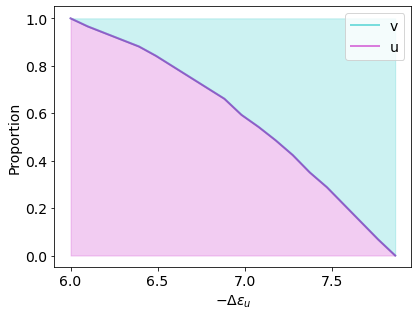

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from Organoid2D import Organoid

org = Organoid()
s_max = org.r_N/org.gamma_N
upper_boundary = -org.eps_G + np.log(1 + np.exp(-org.eps_S-org.eps_GS)*s_max)
eps_N = np.linspace(-org.eps_G, upper_boundary, 20)
Ratio = np.empty(eps_N.shape)

N0 = org.r_N/org.gamma_N*3/4
G0 = org.r_G/org.gamma_G*3/4
u0 = np.append(np.random.normal(N0, N0*0.01, 177),
               np.random.normal(G0, G0*0.01, 177))

for i in range(len(eps_N)):
    org = Organoid()
    org.q = 0.9
    org.signal = 'dispersion'
    org.nofSteps = 1000
    org.dt = org.T/(org.nofSteps - 1)
    org.eps_N = -eps_N[i]
    org.evolution(T = .0001, file = "Organoid_mid.csv", mode = 'transcription')
    org.u = u0
    org.evolution(T = 100, mode = 'transcription')
    F = [1 if org.G[i] >= org.N[i] else 0 for i in range(org.nofCells)]
    Ratio[i] = np.sum(F)/org.nofCells
    print(i)


plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
plt.plot(eps_N, Ratio, 'c', alpha=0.5, lw=2, label = 'v')
plt.plot(eps_N, Ratio, 'm', alpha=0.5, lw=2, label = 'u')
plt.fill_between(eps_N, Ratio, 1, color='c', alpha = 0.2)
plt.fill_between(eps_N, 0, Ratio, color='m', alpha = 0.2)
plt.legend()
plt.xlabel('$-\Delta\epsilon_u$')
plt.ylabel('Proportion')

In [14]:
test = np.zeros(org.GraphDist.shape)
test[org.GraphDist == 1] = 1
test.sum(1).mean()

5.502824858757062

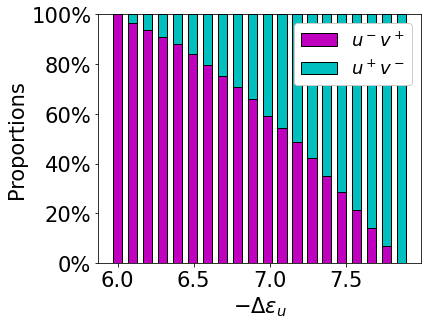

In [10]:
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14*1.5)
plt.bar(eps_N, Ratio*100, width=0.06, color = 'm', edgecolor='k', alpha = 1, label='$u^-v^+$')
plt.bar(eps_N, (1-Ratio)*100, bottom=Ratio*100, width=0.06, color = 'c', edgecolor='k', alpha = 1, label='$u^+v^-$')
ticks = [0,20,40,60,80,100]
plt.yticks(ticks, [str(x)+'%' for x in ticks])
plt.xlabel('$-\Delta\epsilon_u$')
plt.ylabel('Proportions')
plt.gcf().subplots_adjust(bottom=0.16)
plt.gcf().subplots_adjust(left=0.2)
plt.legend(framealpha=1, fontsize=18)
plt.savefig('Results/Publications/Revised Script/Proportions_q=0.9.pdf')
plt.savefig('Results/Publications/Revised Script/Proportions_q=0.9.png')

In [ ]:
PN_mean = np.mean(PN, axis=0)
PN_std = np.std(PN, axis=0)
PG_mean = np.mean(PG, axis=0)
PG_std = np.std(PG, axis=0)


plt.figure()
plt.rc('font', size=14)
distances = [j for j in range(1,int(np.max(FVmesh.GraphDist))+1)]
plt.plot(distances, PN_mean, 'm')
plt.fill_between(distances, PN_mean-PN_std, PN_mean+PN_std, color='m', alpha = 0.2)
plt.ylim([0,2])

plt.rc('font', size=14)
distances = [j for j in range(1,int(np.max(FVmesh.GraphDist))+1)]
plt.plot(distances, PG_mean, 'c')
plt.fill_between(distances, PG_mean-PG_std, PG_mean+PG_std, color='c', alpha = 0.2)

In [ ]:
import matplotlib

cmap = matplotlib.cm.get_cmap('jet')
test = np.linspace(0,1,len(PN)-2)
distances = [j for j in range(1,int(np.max(FVmesh.GraphDist))+1)]
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
for i in range(len(PN)-2):
    rgba = cmap(test[i])
    
    plt.plot(distances,PN[i+1,:], color = rgba, lw=2)
    
plt.xlabel('Distance')
plt.ylabel('$\\rho_n$')
plt.ylim([0-0.12, max([np.max(PN), np.max(PG)])+0.12])
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_n_local.pdf')
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_n_local.png')

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
for i in range(len(PG)-2):
    rgba = cmap(test[i])
    
    plt.plot(distances,PG[i+1,:], color = rgba, lw=2)
    
plt.xlabel('Distance')
plt.ylabel('$\\rho_g$')
plt.ylim([0-0.12, max([np.max(PN), np.max(PG)])+0.12])
#sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=0, vmax=1))
#cbar = plt.colorbar(sm)
#cbar.ax.set_yticklabels([])
#cbar.set_label('$-\Delta\epsilon_g$')
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_g_local.pdf')
plt.savefig('Results/Publications/Pattern Formation/pair_correlation_g_local.png')

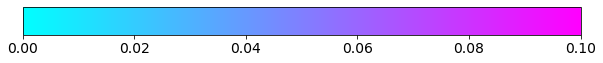

In [13]:
import numpy as np
import matplotlib.pyplot as plt

a = np.array([[0,0.1]])
plt.figure(figsize=(10, 4))
plt.rc('font', size=14)
img = plt.imshow(a, cmap="cool")
plt.gca().set_visible(False)
plt.colorbar(orientation="horizontal", ticks=[0,0.02,0.04,0.06,0.08,0.1])
plt.savefig("Results/Publications/Pattern Formation/colorbar_local.pdf")
plt.savefig("Results/Publications/Pattern Formation/colorbar_local.png")

<br>
<br>
<br>

### ML Training Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from FVmesh import initializeFVmesh
from Organoid2D import initializeOrganoid
from Functions import coverPlot, saveData, paircorrelation, fate
from Model import rhs_activation
from Parameters import setParameters
from scipy.integrate import solve_ivp
import pandas as pd

Prm = setParameters()
#Organoid = initializeOrganoid(Prm, Transcription=False, CellMax=150)
#Pos = Organoid.Pos
#FVmesh = initializeFVmesh(Pos, Radius=Organoid.Radius)

DATA = pd.DataFrame()
for i in range(10):
    #Prm.eps_G = -10.7
    q = np.random.uniform(0,1)
    Prm.range = q
    Prm.nofCells_end = 300# + np.random.normal(0,10)
    Organoid = initializeOrganoid(Prm, Transcription=False, CellMax=150)
    Pos = Organoid.Pos
    FVmesh = initializeFVmesh(Pos, Radius=Organoid.Radius*1.2)
    #Pos = np.array(pd.read_csv('testOrganoid_small.csv'))
    #Radius = np.ones(len(Pos))*1.1
    #FVmesh = initializeFVmesh(Pos, Radius=Organoid.Radius)

    d_ij = FVmesh.GraphDist
    np.fill_diagonal(d_ij, 0)
    s_max = np.max(np.sum(Prm.r_G/Prm.gamma_G*q**d_ij, axis=1))/max(np.sum(q**d_ij, axis=1))
    upper_boundary = -Prm.eps_N + np.log(1 + np.exp(-Prm.eps_S-Prm.eps_NS)*s_max)
    #Prm.eps_G = -np.random.uniform(-Prm.eps_N, upper_boundary)
    Prm.eps_N = -np.random.uniform(-6.8,7.2)#-7
    print('eps_G =', Prm.eps_G, upper_boundary)

    t = np.linspace(0,Prm.T,Prm.nofSteps)

    x0 = [Prm.r_N/Prm.gamma_N*3/4, Prm.r_G/Prm.gamma_G*3/4]
    xInit = np.append(np.random.normal(x0[0], x0[0]*0.01, FVmesh.nofCells),
                      np.random.normal(x0[1], x0[1]*0.01, FVmesh.nofCells))
    rhs = lambda t,x: rhs_activation(0, x, Prm, FVmesh)
    sol = solve_ivp(rhs, [0,Prm.T], xInit, t_eval = t, method = 'Radau')

    N = sol.y[:FVmesh.nofCells,-1]
    G = sol.y[FVmesh.nofCells:,-1]
    F = fate(N,G)

    print('ID =', i, 'Total =', len(N), 'NANOG =', len(N[N>G]), 'GATA6 =', len(G[G>N]))

    df = pd.DataFrame()
    df['ID'] = i*np.ones(len(F), dtype=int)
    df['x'] = Pos[:,0]
    df['y'] = Pos[:,1]
    df['fate'] = F
    df['range'] = q
    DATA = DATA.append(df)

DATA.to_csv('C:/Users/sis85wc/Desktop/ML Training Data/varying range+constrained ratio (Jonas)/Organoids.csv', index=False)

with open('C:/Users/sis85wc/Desktop/ML Training Data/varying range+constrained ratio (Jonas)/Organoids.txt', 'w') as f:
    print('Energy differences---------------------', file=f)
    print('eps_N =', Prm.eps_N, file=f)
    print('eps_G =', Prm.eps_G, file=f)
    print('eps_S =', Prm.eps_S, file=f)
    print('eps_NS =', Prm.eps_NS, file=f)
    print('', file=f)

    print('Reproduction rates---------------------', file=f)
    print('r_N =', Prm.r_N, file=f)
    print('r_G =', Prm.r_G, file=f)
    print('', file=f)

    print('Decay rates----------------------------', file=f)
    print('gamma_N =', Prm.gamma_N, file=f)
    print('gamma_G =', Prm.gamma_G, file=f)
    print('', file=f)

    print('Signal parameters----------------------', file=f)
    print('signal =', Prm.range, file=f)

Expected cell division time = 4.7441202514160725
Expected number of Cells = 193.17431641584017
eps_G = -7 7.865600680126628
ID = 0 Total = 150 NANOG = 60 GATA6 = 90
Expected cell division time = 4.7441202514160725
Expected number of Cells = 193.17431641584017
eps_G = -7 7.865600680126628
ID = 1 Total = 150 NANOG = 70 GATA6 = 80
Expected cell division time = 4.7441202514160725
Expected number of Cells = 193.17431641584017
eps_G = -7 7.865600680126627
ID = 2 Total = 150 NANOG = 80 GATA6 = 70
Expected cell division time = 4.7441202514160725
Expected number of Cells = 193.17431641584017
eps_G = -7 7.865600680126628
ID = 3 Total = 150 NANOG = 71 GATA6 = 79
Expected cell division time = 4.7441202514160725
Expected number of Cells = 193.17431641584017
eps_G = -7 7.865600680126628
ID = 4 Total = 150 NANOG = 84 GATA6 = 66
Expected cell division time = 4.7441202514160725
Expected number of Cells = 193.17431641584017
eps_G = -7 7.865600680126628
ID = 5 Total = 150 NANOG = 73 GATA6 = 77
Expected c

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from FVmesh import initializeFVmesh
from Organoid2D import Organoid
import pandas as pd


DATA = pd.DataFrame()
for i in range(4000):
    org = Organoid()
    org.evolution(T=30, mode='geometry', maxCells=150)
    
    org.eps_N = -np.random.uniform(6.,7.6)
    org.q = np.random.uniform(0,1)
    org.evolution(T=200, mode='transcription')
    F = np.zeros(org.nofCells)
    F[org.G > org.N] = 1

    print('ID =', i, 'Total =', org.nofCells, 'NANOG =', len(org.N[org.N>org.G]), 'GATA6 =', len(org.G[org.G>org.N]), 'q =', org.q)

    df = pd.DataFrame()
    df['ID'] = i*np.ones(org.nofCells, dtype=int)
    df['x'] = org.xy[:,0]
    df['y'] = org.xy[:,1]
    df['fate'] = F
    df['range'] = org.q
    DATA = DATA.append(df)

DATA.to_csv('C:/Users/sis85wc/Desktop/ML Training Data/new_data (Jonas)/Organoids.csv', index=False)

with open('C:/Users/sis85wc/Desktop/ML Training Data/new_data (Jonas)/Organoids.txt', 'w') as f:
    print('Energy differences---------------------', file=f)
    print('eps_N =', org.eps_N, file=f)
    print('eps_G =', org.eps_G, file=f)
    print('eps_S =', org.eps_S, file=f)
    print('eps_NS =', org.eps_GS, file=f)
    print('', file=f)

    print('Reproduction rates---------------------', file=f)
    print('r_N =', org.r_N, file=f)
    print('r_G =', org.r_G, file=f)
    print('', file=f)

    print('Decay rates----------------------------', file=f)
    print('gamma_N =', org.gamma_N, file=f)
    print('gamma_G =', org.gamma_G, file=f)
    print('', file=f)

    print('Signal parameters----------------------', file=f)
    print('signal =', org.q, file=f)

ID = 0 Total = 150 NANOG = 24 GATA6 = 126 q = 0.4064331887787668
ID = 1 Total = 150 NANOG = 131 GATA6 = 19 q = 0.5090743281297209
ID = 2 Total = 150 NANOG = 68 GATA6 = 82 q = 0.20602441248186887
ID = 3 Total = 150 NANOG = 33 GATA6 = 117 q = 0.6120924093244812
ID = 4 Total = 150 NANOG = 71 GATA6 = 79 q = 0.5318888474855316
ID = 5 Total = 150 NANOG = 24 GATA6 = 126 q = 0.47493280559575923
ID = 6 Total = 150 NANOG = 92 GATA6 = 58 q = 0.8693684706824725
ID = 7 Total = 150 NANOG = 32 GATA6 = 118 q = 0.5867159594615702
ID = 8 Total = 150 NANOG = 25 GATA6 = 125 q = 0.6479143614300035
ID = 9 Total = 150 NANOG = 126 GATA6 = 24 q = 0.16290282612412232
ID = 10 Total = 150 NANOG = 89 GATA6 = 61 q = 0.545675683071971
ID = 11 Total = 150 NANOG = 29 GATA6 = 121 q = 0.49372773788537516
ID = 12 Total = 150 NANOG = 27 GATA6 = 123 q = 0.15956038332161016
ID = 13 Total = 150 NANOG = 82 GATA6 = 68 q = 0.8582961872803307
ID = 14 Total = 150 NANOG = 56 GATA6 = 94 q = 0.771501288001799
ID = 15 Total = 150 NAN

ID = 125 Total = 150 NANOG = 90 GATA6 = 60 q = 0.8027986899871224
ID = 126 Total = 150 NANOG = 98 GATA6 = 52 q = 0.7562630906270343
ID = 127 Total = 150 NANOG = 80 GATA6 = 70 q = 0.5957212244035524
ID = 128 Total = 150 NANOG = 25 GATA6 = 125 q = 0.6894349955089456
ID = 129 Total = 150 NANOG = 59 GATA6 = 91 q = 0.06875456038210459
ID = 130 Total = 150 NANOG = 45 GATA6 = 105 q = 0.35852926007198704
ID = 131 Total = 150 NANOG = 55 GATA6 = 95 q = 0.3040641504084278
ID = 132 Total = 150 NANOG = 38 GATA6 = 112 q = 0.7601843246013917
ID = 133 Total = 150 NANOG = 109 GATA6 = 41 q = 0.1567585739642502
ID = 134 Total = 150 NANOG = 14 GATA6 = 136 q = 0.9096306745134681
ID = 135 Total = 150 NANOG = 82 GATA6 = 68 q = 0.11799167755040263
ID = 136 Total = 150 NANOG = 130 GATA6 = 20 q = 0.17095439242325128
ID = 137 Total = 150 NANOG = 41 GATA6 = 109 q = 0.5804735549290125
ID = 138 Total = 150 NANOG = 29 GATA6 = 121 q = 0.8039668086077738
ID = 139 Total = 150 NANOG = 78 GATA6 = 72 q = 0.060832172102001

ID = 248 Total = 150 NANOG = 9 GATA6 = 141 q = 0.723491593841441
ID = 249 Total = 150 NANOG = 19 GATA6 = 131 q = 0.4347900033253478
ID = 250 Total = 150 NANOG = 110 GATA6 = 40 q = 0.7916817200987425
ID = 251 Total = 150 NANOG = 34 GATA6 = 116 q = 0.2304738198526528
ID = 252 Total = 150 NANOG = 4 GATA6 = 146 q = 0.8283653453276304
ID = 253 Total = 150 NANOG = 43 GATA6 = 107 q = 0.08947895389788996
ID = 254 Total = 150 NANOG = 108 GATA6 = 42 q = 0.05768276319834309
ID = 255 Total = 150 NANOG = 50 GATA6 = 100 q = 0.30096750212851553
ID = 256 Total = 150 NANOG = 78 GATA6 = 72 q = 0.8610913883395335
ID = 257 Total = 150 NANOG = 118 GATA6 = 32 q = 0.6363022508102161
ID = 258 Total = 150 NANOG = 99 GATA6 = 51 q = 0.16917948198551425
ID = 259 Total = 150 NANOG = 69 GATA6 = 81 q = 0.7251187971485287
ID = 260 Total = 150 NANOG = 96 GATA6 = 54 q = 0.7443641280923974
ID = 261 Total = 150 NANOG = 114 GATA6 = 36 q = 0.7426837396036045
ID = 262 Total = 150 NANOG = 113 GATA6 = 37 q = 0.573853217458938

ID = 371 Total = 150 NANOG = 4 GATA6 = 146 q = 0.8965926375906527
ID = 372 Total = 150 NANOG = 81 GATA6 = 69 q = 0.0405342752478125
ID = 373 Total = 150 NANOG = 57 GATA6 = 93 q = 0.7112004308375538
ID = 374 Total = 150 NANOG = 122 GATA6 = 28 q = 0.21038442339693098
ID = 375 Total = 150 NANOG = 11 GATA6 = 139 q = 0.9882042137034224
ID = 376 Total = 150 NANOG = 79 GATA6 = 71 q = 0.179541768487125
ID = 377 Total = 150 NANOG = 36 GATA6 = 114 q = 0.9759010303440415
ID = 378 Total = 150 NANOG = 36 GATA6 = 114 q = 0.32698969058292304
ID = 379 Total = 150 NANOG = 118 GATA6 = 32 q = 0.31175469109130693
ID = 380 Total = 150 NANOG = 74 GATA6 = 76 q = 0.2628383523949728
ID = 381 Total = 150 NANOG = 36 GATA6 = 114 q = 0.4156585746967796
ID = 382 Total = 150 NANOG = 91 GATA6 = 59 q = 0.3485435100201484
ID = 383 Total = 150 NANOG = 121 GATA6 = 29 q = 0.06247582266351226
ID = 384 Total = 150 NANOG = 127 GATA6 = 23 q = 0.7729713912426259
ID = 385 Total = 150 NANOG = 81 GATA6 = 69 q = 0.9518342714175476

ID = 494 Total = 150 NANOG = 66 GATA6 = 84 q = 0.7225728845124622
ID = 495 Total = 150 NANOG = 2 GATA6 = 148 q = 0.9252727681995258
ID = 496 Total = 150 NANOG = 58 GATA6 = 92 q = 0.691578931622482
ID = 497 Total = 150 NANOG = 6 GATA6 = 144 q = 0.4137205721385844
ID = 498 Total = 150 NANOG = 57 GATA6 = 93 q = 0.04201586246294431
ID = 499 Total = 150 NANOG = 15 GATA6 = 135 q = 0.9235765552319409
ID = 500 Total = 150 NANOG = 94 GATA6 = 56 q = 0.5555435737852419
ID = 501 Total = 150 NANOG = 45 GATA6 = 105 q = 0.522581757163225
ID = 502 Total = 150 NANOG = 96 GATA6 = 54 q = 0.009150630108627045
ID = 503 Total = 150 NANOG = 82 GATA6 = 68 q = 0.49587544638659975
ID = 504 Total = 150 NANOG = 24 GATA6 = 126 q = 0.33101953107533033
ID = 505 Total = 150 NANOG = 89 GATA6 = 61 q = 0.33017923603379107
ID = 506 Total = 150 NANOG = 117 GATA6 = 33 q = 0.5690835626947578
ID = 507 Total = 150 NANOG = 115 GATA6 = 35 q = 0.034110647331230926
ID = 508 Total = 150 NANOG = 126 GATA6 = 24 q = 0.266532880368005

ID = 617 Total = 150 NANOG = 97 GATA6 = 53 q = 0.755290493108968
ID = 618 Total = 150 NANOG = 134 GATA6 = 16 q = 0.3985954017478375
ID = 619 Total = 150 NANOG = 58 GATA6 = 92 q = 0.45400581043373633
ID = 620 Total = 150 NANOG = 104 GATA6 = 46 q = 0.30387803020716053
ID = 621 Total = 150 NANOG = 37 GATA6 = 113 q = 0.6413356815541414
ID = 622 Total = 150 NANOG = 63 GATA6 = 87 q = 0.5778204810135213
ID = 623 Total = 150 NANOG = 62 GATA6 = 88 q = 0.6749664238252105
ID = 624 Total = 150 NANOG = 113 GATA6 = 37 q = 0.20968910391644913
ID = 625 Total = 150 NANOG = 97 GATA6 = 53 q = 0.0189008388332379
ID = 626 Total = 150 NANOG = 119 GATA6 = 31 q = 0.3552941044810851
ID = 627 Total = 150 NANOG = 5 GATA6 = 145 q = 0.6387338543113872
ID = 628 Total = 150 NANOG = 27 GATA6 = 123 q = 0.6438109151362784
ID = 629 Total = 150 NANOG = 70 GATA6 = 80 q = 0.7025247102115838
ID = 630 Total = 150 NANOG = 45 GATA6 = 105 q = 0.11663389580963068
ID = 631 Total = 150 NANOG = 32 GATA6 = 118 q = 0.5972789558951371

ID = 740 Total = 150 NANOG = 88 GATA6 = 62 q = 0.29983291839569726
ID = 741 Total = 150 NANOG = 36 GATA6 = 114 q = 0.09876933560447976
ID = 742 Total = 150 NANOG = 96 GATA6 = 54 q = 0.6266181659091089
ID = 743 Total = 150 NANOG = 31 GATA6 = 119 q = 0.7565472396482582
ID = 744 Total = 150 NANOG = 57 GATA6 = 93 q = 0.562360931535332
ID = 745 Total = 150 NANOG = 51 GATA6 = 99 q = 0.036676999289405265
ID = 746 Total = 150 NANOG = 92 GATA6 = 58 q = 0.8162106723770371
ID = 747 Total = 150 NANOG = 48 GATA6 = 102 q = 0.9448078807088361
ID = 748 Total = 150 NANOG = 106 GATA6 = 44 q = 0.7112865760652006
ID = 749 Total = 150 NANOG = 117 GATA6 = 33 q = 0.2734653201387711
ID = 750 Total = 150 NANOG = 29 GATA6 = 121 q = 0.7063939224488903
ID = 751 Total = 150 NANOG = 71 GATA6 = 79 q = 0.5001838161213983
ID = 752 Total = 150 NANOG = 114 GATA6 = 36 q = 0.5317410636863904
ID = 753 Total = 150 NANOG = 76 GATA6 = 74 q = 0.1747162094065432
ID = 754 Total = 150 NANOG = 90 GATA6 = 60 q = 0.6074314070886166


ID = 863 Total = 150 NANOG = 67 GATA6 = 83 q = 0.24800546892604647
ID = 864 Total = 150 NANOG = 26 GATA6 = 124 q = 0.06322177304242715
ID = 865 Total = 150 NANOG = 45 GATA6 = 105 q = 0.11281122604114635
ID = 866 Total = 150 NANOG = 131 GATA6 = 19 q = 0.35203194897441303
ID = 867 Total = 150 NANOG = 34 GATA6 = 116 q = 0.514278744378237
ID = 868 Total = 150 NANOG = 73 GATA6 = 77 q = 0.5125695004386621
ID = 869 Total = 150 NANOG = 34 GATA6 = 116 q = 0.5297183173734451
ID = 870 Total = 150 NANOG = 81 GATA6 = 69 q = 0.7098782730202878
ID = 871 Total = 150 NANOG = 9 GATA6 = 141 q = 0.9547594487039992
ID = 872 Total = 150 NANOG = 81 GATA6 = 69 q = 0.13882726923478217
ID = 873 Total = 150 NANOG = 39 GATA6 = 111 q = 0.7357966553607551
ID = 874 Total = 150 NANOG = 15 GATA6 = 135 q = 0.5832028849971186
ID = 875 Total = 150 NANOG = 7 GATA6 = 143 q = 0.8381094002926585
ID = 876 Total = 150 NANOG = 118 GATA6 = 32 q = 0.19896304188050007
ID = 877 Total = 150 NANOG = 28 GATA6 = 122 q = 0.7312169774578

ID = 986 Total = 150 NANOG = 89 GATA6 = 61 q = 0.8507944637619612
ID = 987 Total = 150 NANOG = 127 GATA6 = 23 q = 0.4450774351289942
ID = 988 Total = 150 NANOG = 2 GATA6 = 148 q = 0.8944282343246907
ID = 989 Total = 150 NANOG = 58 GATA6 = 92 q = 0.13554680780911965
ID = 990 Total = 150 NANOG = 84 GATA6 = 66 q = 0.056423056060855514
ID = 991 Total = 150 NANOG = 115 GATA6 = 35 q = 0.6685662314655232
ID = 992 Total = 150 NANOG = 5 GATA6 = 145 q = 0.9101580901874522
ID = 993 Total = 150 NANOG = 18 GATA6 = 132 q = 0.732230697396076
ID = 994 Total = 150 NANOG = 107 GATA6 = 43 q = 0.9528445702928783
ID = 995 Total = 150 NANOG = 77 GATA6 = 73 q = 0.53215227435831
ID = 996 Total = 150 NANOG = 8 GATA6 = 142 q = 0.9416859087383322
ID = 997 Total = 150 NANOG = 12 GATA6 = 138 q = 0.8689821865987054
ID = 998 Total = 150 NANOG = 80 GATA6 = 70 q = 0.2037559279983271
ID = 999 Total = 150 NANOG = 52 GATA6 = 98 q = 0.6790090905746021
ID = 1000 Total = 150 NANOG = 31 GATA6 = 119 q = 0.682271309216062
ID =

ID = 1107 Total = 150 NANOG = 0 GATA6 = 150 q = 0.942632363506098
ID = 1108 Total = 150 NANOG = 69 GATA6 = 81 q = 0.8843106769626907
ID = 1109 Total = 150 NANOG = 130 GATA6 = 20 q = 0.6268716731276199
ID = 1110 Total = 150 NANOG = 76 GATA6 = 74 q = 0.9631828047306042
ID = 1111 Total = 150 NANOG = 37 GATA6 = 113 q = 0.24291442113196215
ID = 1112 Total = 150 NANOG = 99 GATA6 = 51 q = 0.7732204257071293
ID = 1113 Total = 150 NANOG = 13 GATA6 = 137 q = 0.8285773697711789
ID = 1114 Total = 150 NANOG = 69 GATA6 = 81 q = 0.7561759498675406
ID = 1115 Total = 150 NANOG = 84 GATA6 = 66 q = 0.8795350324954919
ID = 1116 Total = 150 NANOG = 98 GATA6 = 52 q = 0.4808661967169562
ID = 1117 Total = 150 NANOG = 45 GATA6 = 105 q = 0.1613260939372294
ID = 1118 Total = 150 NANOG = 125 GATA6 = 25 q = 0.0536499963934175
ID = 1119 Total = 150 NANOG = 101 GATA6 = 49 q = 0.9573720558496752
ID = 1120 Total = 150 NANOG = 114 GATA6 = 36 q = 0.7188656692199593
ID = 1121 Total = 150 NANOG = 9 GATA6 = 141 q = 0.67922

ID = 1228 Total = 150 NANOG = 18 GATA6 = 132 q = 0.1228362144305507
ID = 1229 Total = 150 NANOG = 90 GATA6 = 60 q = 0.7340049572438502
ID = 1230 Total = 150 NANOG = 60 GATA6 = 90 q = 0.14518134360330992
ID = 1231 Total = 150 NANOG = 38 GATA6 = 112 q = 0.4062537350803198
ID = 1232 Total = 150 NANOG = 99 GATA6 = 51 q = 0.13638960355517182
ID = 1233 Total = 150 NANOG = 106 GATA6 = 44 q = 0.2532350686108107
ID = 1234 Total = 150 NANOG = 19 GATA6 = 131 q = 0.486853836115102
ID = 1235 Total = 150 NANOG = 20 GATA6 = 130 q = 0.5500054113840696
ID = 1236 Total = 150 NANOG = 95 GATA6 = 55 q = 0.5587053492519277
ID = 1237 Total = 150 NANOG = 88 GATA6 = 62 q = 0.4001115649906992
ID = 1238 Total = 150 NANOG = 101 GATA6 = 49 q = 0.32043441551480123
ID = 1239 Total = 150 NANOG = 73 GATA6 = 77 q = 0.7737445374809832
ID = 1240 Total = 150 NANOG = 123 GATA6 = 27 q = 0.05974800075626807
ID = 1241 Total = 150 NANOG = 63 GATA6 = 87 q = 0.031018043960809205
ID = 1242 Total = 150 NANOG = 26 GATA6 = 124 q = 0

ID = 1349 Total = 150 NANOG = 130 GATA6 = 20 q = 0.4374768957424062
ID = 1350 Total = 150 NANOG = 8 GATA6 = 142 q = 0.7194531096144119
ID = 1351 Total = 150 NANOG = 97 GATA6 = 53 q = 0.5490598135434537
ID = 1352 Total = 150 NANOG = 39 GATA6 = 111 q = 0.23290602153912787
ID = 1353 Total = 150 NANOG = 102 GATA6 = 48 q = 0.2571399576665012
ID = 1354 Total = 150 NANOG = 54 GATA6 = 96 q = 0.6596740723658074
ID = 1355 Total = 150 NANOG = 131 GATA6 = 19 q = 0.6786298332845467
ID = 1356 Total = 150 NANOG = 127 GATA6 = 23 q = 0.17848167453692243
ID = 1357 Total = 150 NANOG = 64 GATA6 = 86 q = 0.21000906088153226
ID = 1358 Total = 150 NANOG = 25 GATA6 = 125 q = 0.06047193850236343
ID = 1359 Total = 150 NANOG = 132 GATA6 = 18 q = 0.2501148465039682
ID = 1360 Total = 150 NANOG = 57 GATA6 = 93 q = 0.04585940141369638
ID = 1361 Total = 150 NANOG = 101 GATA6 = 49 q = 0.5871422876838904
ID = 1362 Total = 150 NANOG = 76 GATA6 = 74 q = 0.019777602921071225
ID = 1363 Total = 150 NANOG = 34 GATA6 = 116 q 

ID = 1470 Total = 150 NANOG = 45 GATA6 = 105 q = 0.03844838776791981
ID = 1471 Total = 150 NANOG = 88 GATA6 = 62 q = 0.7707419388703476
ID = 1472 Total = 150 NANOG = 10 GATA6 = 140 q = 0.7177299585987552
ID = 1473 Total = 150 NANOG = 67 GATA6 = 83 q = 0.831882810506071
ID = 1474 Total = 150 NANOG = 70 GATA6 = 80 q = 0.23769667098922742
ID = 1475 Total = 150 NANOG = 10 GATA6 = 140 q = 0.613854629247537
ID = 1476 Total = 150 NANOG = 58 GATA6 = 92 q = 0.3584546291737797
ID = 1477 Total = 150 NANOG = 35 GATA6 = 115 q = 0.7765418859872627
ID = 1478 Total = 150 NANOG = 114 GATA6 = 36 q = 0.8026132085237796
ID = 1479 Total = 150 NANOG = 68 GATA6 = 82 q = 0.46354691965399397
ID = 1480 Total = 150 NANOG = 15 GATA6 = 135 q = 0.9898558041164317
ID = 1481 Total = 150 NANOG = 48 GATA6 = 102 q = 0.25523578687408277
ID = 1482 Total = 150 NANOG = 9 GATA6 = 141 q = 0.5470042964990194
ID = 1483 Total = 150 NANOG = 42 GATA6 = 108 q = 0.8229988191787692
ID = 1484 Total = 150 NANOG = 97 GATA6 = 53 q = 0.29

ID = 1591 Total = 150 NANOG = 35 GATA6 = 115 q = 0.6178907787314333
ID = 1592 Total = 150 NANOG = 26 GATA6 = 124 q = 0.09702459238462413
ID = 1593 Total = 150 NANOG = 99 GATA6 = 51 q = 0.23388281206172368
ID = 1594 Total = 150 NANOG = 59 GATA6 = 91 q = 0.7992363977769641
ID = 1595 Total = 150 NANOG = 85 GATA6 = 65 q = 0.5966601985162786
ID = 1596 Total = 150 NANOG = 119 GATA6 = 31 q = 0.3836328994016228
ID = 1597 Total = 150 NANOG = 30 GATA6 = 120 q = 0.274835811930336
ID = 1598 Total = 150 NANOG = 83 GATA6 = 67 q = 0.2528444913443344
ID = 1599 Total = 150 NANOG = 75 GATA6 = 75 q = 0.3422722800107898
ID = 1600 Total = 150 NANOG = 64 GATA6 = 86 q = 0.25948675750514394
ID = 1601 Total = 150 NANOG = 14 GATA6 = 136 q = 0.8072764846293118
ID = 1602 Total = 150 NANOG = 43 GATA6 = 107 q = 0.3909313931242905
ID = 1603 Total = 150 NANOG = 30 GATA6 = 120 q = 0.9216796370222423
ID = 1604 Total = 150 NANOG = 11 GATA6 = 139 q = 0.8313959955120205
ID = 1605 Total = 150 NANOG = 44 GATA6 = 106 q = 0.0

ID = 1712 Total = 150 NANOG = 95 GATA6 = 55 q = 0.004986142119571935
ID = 1713 Total = 150 NANOG = 107 GATA6 = 43 q = 0.7635550866749922
ID = 1714 Total = 150 NANOG = 76 GATA6 = 74 q = 0.530559773389176
ID = 1715 Total = 150 NANOG = 93 GATA6 = 57 q = 0.6659550313738751
ID = 1716 Total = 150 NANOG = 41 GATA6 = 109 q = 0.22915588813047283
ID = 1717 Total = 150 NANOG = 65 GATA6 = 85 q = 0.36222388608011546
ID = 1718 Total = 150 NANOG = 59 GATA6 = 91 q = 0.12929269060027915
ID = 1719 Total = 150 NANOG = 128 GATA6 = 22 q = 0.340138025990266
ID = 1720 Total = 150 NANOG = 21 GATA6 = 129 q = 0.5078698991626626
ID = 1721 Total = 150 NANOG = 79 GATA6 = 71 q = 0.2971378458608027
ID = 1722 Total = 150 NANOG = 18 GATA6 = 132 q = 0.05646619372889783
ID = 1723 Total = 150 NANOG = 58 GATA6 = 92 q = 0.05323246638127266
ID = 1724 Total = 150 NANOG = 13 GATA6 = 137 q = 0.9203357514662144
ID = 1725 Total = 150 NANOG = 110 GATA6 = 40 q = 0.060401900843008116
ID = 1726 Total = 150 NANOG = 138 GATA6 = 12 q =

ID = 1833 Total = 150 NANOG = 34 GATA6 = 116 q = 0.017882713046700416
ID = 1834 Total = 150 NANOG = 31 GATA6 = 119 q = 0.30610005955648756
ID = 1835 Total = 150 NANOG = 28 GATA6 = 122 q = 0.8294980404356455
ID = 1836 Total = 150 NANOG = 63 GATA6 = 87 q = 0.8610014363955205
ID = 1837 Total = 150 NANOG = 80 GATA6 = 70 q = 0.4506004149678533
ID = 1838 Total = 150 NANOG = 120 GATA6 = 30 q = 0.16084144002046663
ID = 1839 Total = 150 NANOG = 44 GATA6 = 106 q = 0.773438783455293
ID = 1840 Total = 150 NANOG = 107 GATA6 = 43 q = 0.9315355479327131
ID = 1841 Total = 150 NANOG = 40 GATA6 = 110 q = 0.3821270411874469
ID = 1842 Total = 150 NANOG = 45 GATA6 = 105 q = 0.046082768246336836
ID = 1843 Total = 150 NANOG = 57 GATA6 = 93 q = 0.7548826934944256
ID = 1844 Total = 150 NANOG = 128 GATA6 = 22 q = 0.6911582853046024
ID = 1845 Total = 150 NANOG = 37 GATA6 = 113 q = 0.23405312622736651
ID = 1846 Total = 150 NANOG = 99 GATA6 = 51 q = 0.18077767402661749
ID = 1847 Total = 150 NANOG = 30 GATA6 = 120 

ID = 1954 Total = 150 NANOG = 107 GATA6 = 43 q = 0.6948242039738787
ID = 1955 Total = 150 NANOG = 92 GATA6 = 58 q = 0.8778853855902402
ID = 1956 Total = 150 NANOG = 64 GATA6 = 86 q = 0.6654964590516316
ID = 1957 Total = 150 NANOG = 67 GATA6 = 83 q = 0.9193347955875342
ID = 1958 Total = 150 NANOG = 15 GATA6 = 135 q = 0.7315931674622459
ID = 1959 Total = 150 NANOG = 18 GATA6 = 132 q = 0.8579752731953962
ID = 1960 Total = 150 NANOG = 5 GATA6 = 145 q = 0.23533861457312766
ID = 1961 Total = 150 NANOG = 85 GATA6 = 65 q = 0.08607148012030863
ID = 1962 Total = 150 NANOG = 89 GATA6 = 61 q = 0.24836637182351906
ID = 1963 Total = 150 NANOG = 105 GATA6 = 45 q = 0.7375388431404519
ID = 1964 Total = 150 NANOG = 50 GATA6 = 100 q = 0.8840764077876915
ID = 1965 Total = 150 NANOG = 106 GATA6 = 44 q = 0.7515666959649443
ID = 1966 Total = 150 NANOG = 47 GATA6 = 103 q = 0.14446743192972833
ID = 1967 Total = 150 NANOG = 71 GATA6 = 79 q = 0.06629904512292928
ID = 1968 Total = 150 NANOG = 81 GATA6 = 69 q = 0.

ID = 2075 Total = 150 NANOG = 8 GATA6 = 142 q = 0.2574713452442805
ID = 2076 Total = 150 NANOG = 9 GATA6 = 141 q = 0.5606465677398619
ID = 2077 Total = 150 NANOG = 111 GATA6 = 39 q = 0.4701081541357468
ID = 2078 Total = 150 NANOG = 25 GATA6 = 125 q = 0.42942892271935773
ID = 2079 Total = 150 NANOG = 42 GATA6 = 108 q = 0.018222898807018106
ID = 2080 Total = 150 NANOG = 23 GATA6 = 127 q = 0.4650840065352575
ID = 2081 Total = 150 NANOG = 20 GATA6 = 130 q = 0.9353447813189653
ID = 2082 Total = 150 NANOG = 45 GATA6 = 105 q = 0.41485143847239825
ID = 2083 Total = 150 NANOG = 4 GATA6 = 146 q = 0.9906127063566693
ID = 2084 Total = 150 NANOG = 73 GATA6 = 77 q = 0.6163074161205696
ID = 2085 Total = 150 NANOG = 60 GATA6 = 90 q = 0.9106005048477694
ID = 2086 Total = 150 NANOG = 41 GATA6 = 109 q = 0.18308490989838233
ID = 2087 Total = 150 NANOG = 50 GATA6 = 100 q = 0.5228955193021144
ID = 2088 Total = 150 NANOG = 46 GATA6 = 104 q = 0.880085981887147
ID = 2089 Total = 150 NANOG = 20 GATA6 = 130 q = 

ID = 2196 Total = 150 NANOG = 39 GATA6 = 111 q = 0.33326109631816514
ID = 2197 Total = 150 NANOG = 35 GATA6 = 115 q = 0.78412475758563
ID = 2198 Total = 150 NANOG = 22 GATA6 = 128 q = 0.3217354345195158
ID = 2199 Total = 150 NANOG = 18 GATA6 = 132 q = 0.1711309488983751
ID = 2200 Total = 150 NANOG = 21 GATA6 = 129 q = 0.531403615178388
ID = 2201 Total = 150 NANOG = 134 GATA6 = 16 q = 0.5486280968486583
ID = 2202 Total = 150 NANOG = 116 GATA6 = 34 q = 0.3551010530616351
ID = 2203 Total = 150 NANOG = 71 GATA6 = 79 q = 0.06241838487793139
ID = 2204 Total = 150 NANOG = 60 GATA6 = 90 q = 0.9836560879644556
ID = 2205 Total = 150 NANOG = 54 GATA6 = 96 q = 0.972954639741806
ID = 2206 Total = 150 NANOG = 132 GATA6 = 18 q = 0.6628944133914992
ID = 2207 Total = 150 NANOG = 24 GATA6 = 126 q = 0.6432134164969582
ID = 2208 Total = 150 NANOG = 72 GATA6 = 78 q = 0.6471819025249941
ID = 2209 Total = 150 NANOG = 37 GATA6 = 113 q = 0.42601025278782356
ID = 2210 Total = 150 NANOG = 45 GATA6 = 105 q = 0.55

ID = 2317 Total = 150 NANOG = 45 GATA6 = 105 q = 0.4954823243841785
ID = 2318 Total = 150 NANOG = 134 GATA6 = 16 q = 0.06942443685247468
ID = 2319 Total = 150 NANOG = 12 GATA6 = 138 q = 0.5195702471563745
ID = 2320 Total = 150 NANOG = 7 GATA6 = 143 q = 0.5285640180469301
ID = 2321 Total = 150 NANOG = 83 GATA6 = 67 q = 0.09934019740470812
ID = 2322 Total = 150 NANOG = 125 GATA6 = 25 q = 0.8197131384326637
ID = 2323 Total = 150 NANOG = 39 GATA6 = 111 q = 0.2915979484437261
ID = 2324 Total = 150 NANOG = 39 GATA6 = 111 q = 0.3052307222145959
ID = 2325 Total = 150 NANOG = 35 GATA6 = 115 q = 0.24893323717412796
ID = 2326 Total = 150 NANOG = 39 GATA6 = 111 q = 0.6316513509492346
ID = 2327 Total = 150 NANOG = 103 GATA6 = 47 q = 0.07329592121197648
ID = 2328 Total = 150 NANOG = 35 GATA6 = 115 q = 0.3896489762136798
ID = 2329 Total = 150 NANOG = 87 GATA6 = 63 q = 0.7609075276414853
ID = 2330 Total = 150 NANOG = 127 GATA6 = 23 q = 0.7274791490124696
ID = 2331 Total = 150 NANOG = 101 GATA6 = 49 q 

ID = 2438 Total = 150 NANOG = 45 GATA6 = 105 q = 0.3494352197987065
ID = 2439 Total = 150 NANOG = 44 GATA6 = 106 q = 0.014385987882137963
ID = 2440 Total = 150 NANOG = 124 GATA6 = 26 q = 0.0189479896359368
ID = 2441 Total = 150 NANOG = 35 GATA6 = 115 q = 0.20629809890336281
ID = 2442 Total = 150 NANOG = 55 GATA6 = 95 q = 0.4177295490379376
ID = 2443 Total = 150 NANOG = 94 GATA6 = 56 q = 0.8070055807726858
ID = 2444 Total = 150 NANOG = 44 GATA6 = 106 q = 0.23403941580593202
ID = 2445 Total = 150 NANOG = 6 GATA6 = 144 q = 0.9612521537418038
ID = 2446 Total = 150 NANOG = 31 GATA6 = 119 q = 0.6835446548349208
ID = 2447 Total = 150 NANOG = 57 GATA6 = 93 q = 0.5502445389390752
ID = 2448 Total = 150 NANOG = 25 GATA6 = 125 q = 0.7623980497436579
ID = 2449 Total = 150 NANOG = 47 GATA6 = 103 q = 0.014418297125425528
ID = 2450 Total = 150 NANOG = 25 GATA6 = 125 q = 0.32176182555437105
ID = 2451 Total = 150 NANOG = 84 GATA6 = 66 q = 0.818635653829576
ID = 2452 Total = 150 NANOG = 70 GATA6 = 80 q =

ID = 2559 Total = 150 NANOG = 25 GATA6 = 125 q = 0.21812475035697054
ID = 2560 Total = 150 NANOG = 46 GATA6 = 104 q = 0.03546248452174028
ID = 2561 Total = 150 NANOG = 58 GATA6 = 92 q = 0.8837263313668995
ID = 2562 Total = 150 NANOG = 54 GATA6 = 96 q = 0.9151146033557807
ID = 2563 Total = 150 NANOG = 121 GATA6 = 29 q = 0.910073572686539
ID = 2564 Total = 150 NANOG = 59 GATA6 = 91 q = 0.934091949453092
ID = 2565 Total = 150 NANOG = 38 GATA6 = 112 q = 0.9594711599453377
ID = 2566 Total = 150 NANOG = 64 GATA6 = 86 q = 0.9573209112229997
ID = 2567 Total = 150 NANOG = 98 GATA6 = 52 q = 0.8763246007902408
ID = 2568 Total = 150 NANOG = 46 GATA6 = 104 q = 0.030083922514358874
ID = 2569 Total = 150 NANOG = 96 GATA6 = 54 q = 0.6842171716715325
ID = 2570 Total = 150 NANOG = 82 GATA6 = 68 q = 0.5256249687618908
ID = 2571 Total = 150 NANOG = 45 GATA6 = 105 q = 0.0013118063864853147
ID = 2572 Total = 150 NANOG = 43 GATA6 = 107 q = 0.09701141055595819
ID = 2573 Total = 150 NANOG = 91 GATA6 = 59 q = 0

ID = 2680 Total = 150 NANOG = 22 GATA6 = 128 q = 0.46056359375390776
ID = 2681 Total = 150 NANOG = 19 GATA6 = 131 q = 0.7326593558331497
ID = 2682 Total = 150 NANOG = 97 GATA6 = 53 q = 0.008508351844124795
ID = 2683 Total = 150 NANOG = 90 GATA6 = 60 q = 0.8886069212098804
ID = 2684 Total = 150 NANOG = 9 GATA6 = 141 q = 0.6995958416450341
ID = 2685 Total = 150 NANOG = 116 GATA6 = 34 q = 0.8833723060273668
ID = 2686 Total = 150 NANOG = 40 GATA6 = 110 q = 0.6513511300088973
ID = 2687 Total = 150 NANOG = 8 GATA6 = 142 q = 0.728565544247574
ID = 2688 Total = 150 NANOG = 69 GATA6 = 81 q = 0.4790318525283235
ID = 2689 Total = 150 NANOG = 40 GATA6 = 110 q = 0.9991456733327079
ID = 2690 Total = 150 NANOG = 25 GATA6 = 125 q = 0.5659963046973535
ID = 2691 Total = 150 NANOG = 57 GATA6 = 93 q = 0.054481494923660834
ID = 2692 Total = 150 NANOG = 8 GATA6 = 142 q = 0.8895482361764684
ID = 2693 Total = 150 NANOG = 25 GATA6 = 125 q = 0.14484332815051704
ID = 2694 Total = 150 NANOG = 33 GATA6 = 117 q = 0

ID = 2802 Total = 150 NANOG = 80 GATA6 = 70 q = 0.7886412128918163
ID = 2803 Total = 150 NANOG = 109 GATA6 = 41 q = 0.6326718143758258
ID = 2804 Total = 150 NANOG = 1 GATA6 = 149 q = 0.8099404085051273
ID = 2805 Total = 150 NANOG = 90 GATA6 = 60 q = 0.6737491043489454
ID = 2806 Total = 150 NANOG = 133 GATA6 = 17 q = 0.28576494914668726
ID = 2807 Total = 150 NANOG = 97 GATA6 = 53 q = 0.7426682596922654
ID = 2808 Total = 150 NANOG = 41 GATA6 = 109 q = 0.40649596808944366
ID = 2809 Total = 150 NANOG = 37 GATA6 = 113 q = 0.7943846766814299
ID = 2810 Total = 150 NANOG = 82 GATA6 = 68 q = 0.3331455462070477
ID = 2811 Total = 150 NANOG = 106 GATA6 = 44 q = 0.8847537264210729
ID = 2812 Total = 150 NANOG = 128 GATA6 = 22 q = 0.4592540303400261
ID = 2813 Total = 150 NANOG = 110 GATA6 = 40 q = 0.18763350037864523
ID = 2814 Total = 150 NANOG = 63 GATA6 = 87 q = 0.8819533914241514
ID = 2815 Total = 150 NANOG = 33 GATA6 = 117 q = 0.08439939702099286
ID = 2816 Total = 150 NANOG = 4 GATA6 = 146 q = 0.

ID = 2923 Total = 150 NANOG = 102 GATA6 = 48 q = 0.22748551856583954
ID = 2924 Total = 150 NANOG = 25 GATA6 = 125 q = 0.8397263634418871
ID = 2925 Total = 150 NANOG = 126 GATA6 = 24 q = 0.6616094868110881
ID = 2926 Total = 150 NANOG = 130 GATA6 = 20 q = 0.605298081062167
ID = 2927 Total = 150 NANOG = 5 GATA6 = 145 q = 0.5837999282174762
ID = 2928 Total = 150 NANOG = 95 GATA6 = 55 q = 0.5517754288840455
ID = 2929 Total = 150 NANOG = 15 GATA6 = 135 q = 0.7895386715313
ID = 2930 Total = 150 NANOG = 30 GATA6 = 120 q = 0.41037521025578705
ID = 2931 Total = 150 NANOG = 109 GATA6 = 41 q = 0.35218724934568935
ID = 2932 Total = 150 NANOG = 3 GATA6 = 147 q = 0.9441011002456834
ID = 2933 Total = 150 NANOG = 12 GATA6 = 138 q = 0.856141095529459
ID = 2934 Total = 150 NANOG = 84 GATA6 = 66 q = 0.9857173648279357
ID = 2935 Total = 150 NANOG = 27 GATA6 = 123 q = 0.4942954824204857
ID = 2936 Total = 150 NANOG = 60 GATA6 = 90 q = 0.16282146357702076
ID = 2937 Total = 150 NANOG = 53 GATA6 = 97 q = 0.0901

ID = 3044 Total = 150 NANOG = 99 GATA6 = 51 q = 0.8547694231649502
ID = 3045 Total = 150 NANOG = 22 GATA6 = 128 q = 0.6495344146109162
ID = 3046 Total = 150 NANOG = 79 GATA6 = 71 q = 0.5075160089627236
ID = 3047 Total = 150 NANOG = 125 GATA6 = 25 q = 0.6575335434812836
ID = 3048 Total = 150 NANOG = 60 GATA6 = 90 q = 0.35043038990603226
ID = 3049 Total = 150 NANOG = 18 GATA6 = 132 q = 0.9068695143849911
ID = 3050 Total = 150 NANOG = 55 GATA6 = 95 q = 0.9639904817133674
ID = 3051 Total = 150 NANOG = 38 GATA6 = 112 q = 0.5857957136261478
ID = 3052 Total = 150 NANOG = 73 GATA6 = 77 q = 0.29183754215382707
ID = 3053 Total = 150 NANOG = 71 GATA6 = 79 q = 0.20888383032444136
ID = 3054 Total = 150 NANOG = 55 GATA6 = 95 q = 0.7827281277357188
ID = 3055 Total = 150 NANOG = 58 GATA6 = 92 q = 0.1348514450851861
ID = 3056 Total = 150 NANOG = 17 GATA6 = 133 q = 0.6938782430181277
ID = 3057 Total = 150 NANOG = 31 GATA6 = 119 q = 0.9889029913308294
ID = 3058 Total = 150 NANOG = 40 GATA6 = 110 q = 0.19

ID = 3165 Total = 150 NANOG = 34 GATA6 = 116 q = 0.30623336346858265
ID = 3166 Total = 150 NANOG = 58 GATA6 = 92 q = 0.11985397157122979
ID = 3167 Total = 150 NANOG = 36 GATA6 = 114 q = 0.10378003398343583
ID = 3168 Total = 150 NANOG = 57 GATA6 = 93 q = 0.056055081386062744
ID = 3169 Total = 150 NANOG = 72 GATA6 = 78 q = 0.9437446712638213
ID = 3170 Total = 150 NANOG = 29 GATA6 = 121 q = 0.4022844585581262
ID = 3171 Total = 150 NANOG = 39 GATA6 = 111 q = 0.9331197007307989
ID = 3172 Total = 150 NANOG = 103 GATA6 = 47 q = 0.17157429665432344
ID = 3173 Total = 150 NANOG = 14 GATA6 = 136 q = 0.7309150141372742
ID = 3174 Total = 150 NANOG = 76 GATA6 = 74 q = 0.96555190774329
ID = 3175 Total = 150 NANOG = 33 GATA6 = 117 q = 0.5535242634959318
ID = 3176 Total = 150 NANOG = 44 GATA6 = 106 q = 0.5109537836020711
ID = 3177 Total = 150 NANOG = 48 GATA6 = 102 q = 0.6137883003782358
ID = 3178 Total = 150 NANOG = 30 GATA6 = 120 q = 0.11256141126084829
ID = 3179 Total = 150 NANOG = 95 GATA6 = 55 q =

ID = 3286 Total = 150 NANOG = 42 GATA6 = 108 q = 0.4885351265463821
ID = 3287 Total = 150 NANOG = 35 GATA6 = 115 q = 0.9734205532513777
ID = 3288 Total = 150 NANOG = 56 GATA6 = 94 q = 0.16714618773738488
ID = 3289 Total = 150 NANOG = 1 GATA6 = 149 q = 0.8566986006026951
ID = 3290 Total = 150 NANOG = 41 GATA6 = 109 q = 0.6043677334039298
ID = 3291 Total = 150 NANOG = 115 GATA6 = 35 q = 0.7076829528637615
ID = 3292 Total = 150 NANOG = 77 GATA6 = 73 q = 0.8581292005193399
ID = 3293 Total = 150 NANOG = 133 GATA6 = 17 q = 0.4666439431501582
ID = 3294 Total = 150 NANOG = 124 GATA6 = 26 q = 0.5703835802900532
ID = 3295 Total = 150 NANOG = 56 GATA6 = 94 q = 0.11665743376385773
ID = 3296 Total = 150 NANOG = 10 GATA6 = 140 q = 0.6692224250806956
ID = 3297 Total = 150 NANOG = 19 GATA6 = 131 q = 0.7506998721510312
ID = 3298 Total = 150 NANOG = 58 GATA6 = 92 q = 0.029729819136459
ID = 3299 Total = 150 NANOG = 107 GATA6 = 43 q = 0.7405366087866061
ID = 3300 Total = 150 NANOG = 60 GATA6 = 90 q = 0.31

ID = 3407 Total = 150 NANOG = 23 GATA6 = 127 q = 0.33883879894189495
ID = 3408 Total = 150 NANOG = 60 GATA6 = 90 q = 0.6435292685596853
ID = 3409 Total = 150 NANOG = 120 GATA6 = 30 q = 0.25911718781978554
ID = 3410 Total = 150 NANOG = 50 GATA6 = 100 q = 0.15354039692335508
ID = 3411 Total = 150 NANOG = 31 GATA6 = 119 q = 0.8062212198320949
ID = 3412 Total = 150 NANOG = 21 GATA6 = 129 q = 0.5567978631595258
ID = 3413 Total = 150 NANOG = 50 GATA6 = 100 q = 0.8569043349896992
ID = 3414 Total = 150 NANOG = 14 GATA6 = 136 q = 0.34438651263556197
ID = 3415 Total = 150 NANOG = 71 GATA6 = 79 q = 0.9675405941597612
ID = 3416 Total = 150 NANOG = 76 GATA6 = 74 q = 0.5357769332608927
ID = 3417 Total = 150 NANOG = 100 GATA6 = 50 q = 0.6300653829102346
ID = 3418 Total = 150 NANOG = 6 GATA6 = 144 q = 0.5493945302357957
ID = 3419 Total = 150 NANOG = 12 GATA6 = 138 q = 0.6693837734896314
ID = 3420 Total = 150 NANOG = 71 GATA6 = 79 q = 0.550279204542636
ID = 3421 Total = 150 NANOG = 108 GATA6 = 42 q = 0

ID = 3528 Total = 150 NANOG = 41 GATA6 = 109 q = 0.16439034594958968
ID = 3529 Total = 150 NANOG = 61 GATA6 = 89 q = 0.2253607849874586
ID = 3530 Total = 150 NANOG = 44 GATA6 = 106 q = 0.045606360479293895
ID = 3531 Total = 150 NANOG = 19 GATA6 = 131 q = 0.4334939033478922
ID = 3532 Total = 150 NANOG = 12 GATA6 = 138 q = 0.22521032700510535
ID = 3533 Total = 150 NANOG = 78 GATA6 = 72 q = 0.05536929939549651
ID = 3534 Total = 150 NANOG = 109 GATA6 = 41 q = 0.846903386067968
ID = 3535 Total = 150 NANOG = 65 GATA6 = 85 q = 0.15940555778340604
ID = 3536 Total = 150 NANOG = 109 GATA6 = 41 q = 0.6305474035094176
ID = 3537 Total = 150 NANOG = 21 GATA6 = 129 q = 0.9731971034938716
ID = 3538 Total = 150 NANOG = 124 GATA6 = 26 q = 0.7441217955938183
ID = 3539 Total = 150 NANOG = 78 GATA6 = 72 q = 0.6619797570389457
ID = 3540 Total = 150 NANOG = 105 GATA6 = 45 q = 0.33893843825782755
ID = 3541 Total = 150 NANOG = 18 GATA6 = 132 q = 0.4162779208733971
ID = 3542 Total = 150 NANOG = 15 GATA6 = 135 q

ID = 3649 Total = 150 NANOG = 52 GATA6 = 98 q = 0.2289241435060939
ID = 3650 Total = 150 NANOG = 70 GATA6 = 80 q = 0.41497645747508105
ID = 3651 Total = 150 NANOG = 110 GATA6 = 40 q = 0.28512945407920853
ID = 3652 Total = 150 NANOG = 10 GATA6 = 140 q = 0.4776938122747729
ID = 3653 Total = 150 NANOG = 60 GATA6 = 90 q = 0.6932356705059206
ID = 3654 Total = 150 NANOG = 49 GATA6 = 101 q = 0.47927841254856696
ID = 3655 Total = 150 NANOG = 129 GATA6 = 21 q = 0.5616017793727628
ID = 3656 Total = 150 NANOG = 29 GATA6 = 121 q = 0.9041539058871134
ID = 3657 Total = 150 NANOG = 106 GATA6 = 44 q = 0.14934161820908587
ID = 3658 Total = 150 NANOG = 98 GATA6 = 52 q = 0.32397937346648753
ID = 3659 Total = 150 NANOG = 72 GATA6 = 78 q = 0.39972785712838965
ID = 3660 Total = 150 NANOG = 19 GATA6 = 131 q = 0.8538864772639311
ID = 3661 Total = 150 NANOG = 46 GATA6 = 104 q = 0.015269141936706365
ID = 3662 Total = 150 NANOG = 14 GATA6 = 136 q = 0.9933823830861246
ID = 3663 Total = 150 NANOG = 18 GATA6 = 132 

ID = 3770 Total = 150 NANOG = 40 GATA6 = 110 q = 0.03794566583352865
ID = 3771 Total = 150 NANOG = 58 GATA6 = 92 q = 0.9242590732279418
ID = 3772 Total = 150 NANOG = 48 GATA6 = 102 q = 0.6836980305419669
ID = 3773 Total = 150 NANOG = 22 GATA6 = 128 q = 0.9987888899255621
ID = 3774 Total = 150 NANOG = 57 GATA6 = 93 q = 0.05579951530356975
ID = 3775 Total = 150 NANOG = 103 GATA6 = 47 q = 0.3979342286577321
ID = 3776 Total = 150 NANOG = 89 GATA6 = 61 q = 0.5824683820272879
ID = 3777 Total = 150 NANOG = 55 GATA6 = 95 q = 0.34021910559498314
ID = 3778 Total = 150 NANOG = 39 GATA6 = 111 q = 0.21704202193596212
ID = 3779 Total = 150 NANOG = 116 GATA6 = 34 q = 0.777672313530039
ID = 3780 Total = 150 NANOG = 55 GATA6 = 95 q = 0.28263235444168966
ID = 3781 Total = 150 NANOG = 38 GATA6 = 112 q = 0.9949317905336192
ID = 3782 Total = 150 NANOG = 17 GATA6 = 133 q = 0.9515611713155597
ID = 3783 Total = 150 NANOG = 105 GATA6 = 45 q = 0.8426438948299718
ID = 3784 Total = 150 NANOG = 53 GATA6 = 97 q = 0

ID = 3891 Total = 150 NANOG = 133 GATA6 = 17 q = 0.5637133569424938
ID = 3892 Total = 150 NANOG = 74 GATA6 = 76 q = 0.4377319435253194
ID = 3893 Total = 150 NANOG = 35 GATA6 = 115 q = 0.8236756363435702
ID = 3894 Total = 150 NANOG = 44 GATA6 = 106 q = 0.211078401634736
ID = 3895 Total = 150 NANOG = 82 GATA6 = 68 q = 0.7538384437032049
ID = 3896 Total = 150 NANOG = 78 GATA6 = 72 q = 0.3165118717429388
ID = 3897 Total = 150 NANOG = 45 GATA6 = 105 q = 0.45156312649777874
ID = 3898 Total = 150 NANOG = 89 GATA6 = 61 q = 0.9927550717005255
ID = 3899 Total = 150 NANOG = 69 GATA6 = 81 q = 0.5025326314593965
ID = 3900 Total = 150 NANOG = 66 GATA6 = 84 q = 0.29928202972660445
ID = 3901 Total = 150 NANOG = 97 GATA6 = 53 q = 0.11392055281888458
ID = 3902 Total = 150 NANOG = 25 GATA6 = 125 q = 0.3132909204357992
ID = 3903 Total = 150 NANOG = 44 GATA6 = 106 q = 0.08137215223876337
ID = 3904 Total = 150 NANOG = 12 GATA6 = 138 q = 0.6515383801009375
ID = 3905 Total = 150 NANOG = 58 GATA6 = 92 q = 0.99

In [24]:
DATA.to_csv('C:/Users/sis85wc/Desktop/ML Training Data/new_data (Jonas)/Organoids.csv', index=False)

In [3]:
from Organoid3D import Organoid
from Functions import fate
import pandas as pd
import numpy as np

Q = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for q in Q:
    DATA = pd.DataFrame()
    for i in range(100):
        org = Organoid()
        org.q = q
        org.evolution(T=25, mode='geometry')
        org.evolution(T=25, mode='transcription')
        F = fate(org.N,org.G)

        print('ID =', i, 'Total =', len(org.N), 'NANOG =', len(org.N[org.N>org.G]), 'GATA6 =', len(org.G[org.G>org.N]))

        df = pd.DataFrame()
        df['ID'] = i*np.ones(len(F), dtype=int)
        df['x'] = org.xyz[:,0]
        df['y'] = org.xyz[:,1]
        df['z'] = org.xyz[:,2]
        df['fate'] = F
        DATA = DATA.append(df)
    
    DATA.to_csv('C:/Users/sis85wc/Desktop/ML Training Data/varying cell numbers 3D (Robin)/Organoids q='+str(q)+'.csv', index=False)

ID = 0 Total = 334 NANOG = 137 GATA6 = 197
ID = 1 Total = 359 NANOG = 156 GATA6 = 203
ID = 2 Total = 298 NANOG = 126 GATA6 = 172
ID = 3 Total = 357 NANOG = 152 GATA6 = 205
ID = 4 Total = 326 NANOG = 139 GATA6 = 187
ID = 5 Total = 286 NANOG = 124 GATA6 = 162
ID = 6 Total = 362 NANOG = 159 GATA6 = 203
ID = 7 Total = 319 NANOG = 128 GATA6 = 191
ID = 8 Total = 327 NANOG = 134 GATA6 = 193
ID = 9 Total = 338 NANOG = 141 GATA6 = 197
ID = 10 Total = 290 NANOG = 127 GATA6 = 163
ID = 11 Total = 299 NANOG = 124 GATA6 = 175
ID = 12 Total = 356 NANOG = 161 GATA6 = 195
ID = 13 Total = 313 NANOG = 131 GATA6 = 182
ID = 14 Total = 353 NANOG = 147 GATA6 = 206
ID = 15 Total = 359 NANOG = 151 GATA6 = 208
ID = 16 Total = 340 NANOG = 148 GATA6 = 192
ID = 17 Total = 308 NANOG = 127 GATA6 = 181
ID = 18 Total = 304 NANOG = 122 GATA6 = 182
ID = 19 Total = 308 NANOG = 129 GATA6 = 179
ID = 20 Total = 328 NANOG = 129 GATA6 = 199
ID = 21 Total = 300 NANOG = 133 GATA6 = 167
ID = 22 Total = 344 NANOG = 151 GATA6 = 19

In [1]:
from Organoid3D import Organoid
from scipy.spatial import Delaunay
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import numpy as np
import itertools

org = Organoid()
org.evolution(T=28, mode='geometry')
org.evolution(T=20, mode='transcription')
org.cellPlot(org.N, size=0)

#### 3D data (varying cell number and $q$) for pattern recognition

In [2]:
import numpy as np
from ExpData import ExpData

data = ExpData("Data/includingSurfaceDistance/extendedRawDataICMOrganoids.csv")

mean24 = 0
mean48 = 0
for i in np.unique(data.id):
    if data.stage[data.id == i][0] == '24h':
        mean24 += len(data.id[data.id == i])/34
    if data.stage[data.id == i][0] == '48h':
        mean48 += len(data.id[data.id == i])/42
        
print('24h organoids have a mean of '+str(mean24)+' cells')
print('48h organoids have a mean of '+str(mean48)+' cells')

24h organoids have a mean of 441.735294117647 cells
48h organoids have a mean of 1041.2380952380954 cells


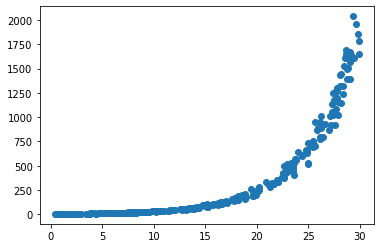

In [6]:
from Organoid3D import Organoid
import matplotlib.pyplot as plt

Ts = []
Ns = []
for i in range(300):
    T = np.random.uniform(0,30)
    
    org = Organoid()
    org.evolution(T=T, mode = 'geometry')
    
    Ts.append(T)
    Ns.append(org.nofCells)
    
plt.scatter(Ts, Ns)

[0.2162058]


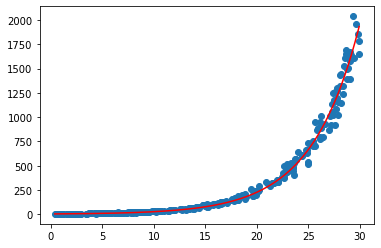

In [11]:
from scipy.optimize import curve_fit

f = lambda t, a: np.exp(a*t)*3

popt, pcov = curve_fit(f, Ts, Ns)

plt.scatter(Ts, Ns)
t = np.linspace(min(Ts), max(Ts), 1000)
plt.plot(t, f(t, *popt), 'r')

In [13]:
T24 = np.log(mean24/3)/popt[0]
T48 = np.log(mean48/3)/popt[0]

print("The time to reach an average of " + str(mean24) + " cells is " + str(T24))
print("The time to reach an average of " + str(mean48) + " cells is " + str(T48))

The time to reach an average of 441.735294117647 cells is 23.089568326350786
The time to reach an average of 1041.2380952380954 cells is 27.05548852803504


In [9]:
T24 = 23.089568326350786
T48 = 27.05548852803504

In [7]:
from Organoid3D import Organoid
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

DATA = pd.DataFrame()
for i in range(1000):
    org = Organoid()
    org.nofSteps = 6000
    org.evolution(T=T24, mode='geometry')
    
    org.eps_N = -np.random.uniform(6.,7.6)
    org.q = np.random.uniform(0,1)
    org.nofSteps = 1000
    org.evolution(T=20, mode='transcription')
    F = np.zeros(org.nofCells)
    F[org.G > org.N] = 1

    print('ID =', i, 'Total =', org.nofCells, 'NANOG =', len(org.N[org.N>org.G]), 'GATA6 =', len(org.G[org.G>org.N]), 'q =', org.q)

    df = pd.DataFrame()
    df['ID'] = i*np.ones(org.nofCells, dtype=int)
    df['x'] = org.xyz[:,0]
    df['y'] = org.xyz[:,1]
    df['z'] = org.xyz[:,2]
    df['fate'] = F
    df['range'] = org.q
    DATA = DATA.append(df)

DATA.to_csv('C:/Users/sis85wc/Desktop/ML Training Data/pattern recognition/3D_24h.csv', index=False)



with open('C:/Users/sis85wc/Desktop/ML Training Data/pattern recognition/3D_24h.txt', 'w') as f:
    print('Energy differences---------------------', file=f)
    print('eps_N =', org.eps_N, file=f)
    print('eps_G =', org.eps_G, file=f)
    print('eps_S =', org.eps_S, file=f)
    print('eps_NS =', org.eps_GS, file=f)
    print('', file=f)

    print('Reproduction rates---------------------', file=f)
    print('r_N =', org.r_N, file=f)
    print('r_G =', org.r_G, file=f)
    print('', file=f)

    print('Decay rates----------------------------', file=f)
    print('gamma_N =', org.gamma_N, file=f)
    print('gamma_G =', org.gamma_G, file=f)
    print('', file=f)

    print('Signal parameters----------------------', file=f)
    print('signal =', org.q, file=f)

ID = 0 Total = 468 NANOG = 72 GATA6 = 396 q = 0.06642630034052643
ID = 1 Total = 514 NANOG = 423 GATA6 = 91 q = 0.740006569045751
ID = 2 Total = 478 NANOG = 358 GATA6 = 120 q = 0.05292636573538101
ID = 3 Total = 480 NANOG = 370 GATA6 = 110 q = 0.7815637783056948
ID = 4 Total = 470 NANOG = 102 GATA6 = 368 q = 0.526518056930637
ID = 5 Total = 485 NANOG = 331 GATA6 = 154 q = 0.22074463892203455
ID = 6 Total = 551 NANOG = 137 GATA6 = 414 q = 0.7095539629226619
ID = 7 Total = 550 NANOG = 74 GATA6 = 476 q = 0.9187754894820263
ID = 8 Total = 477 NANOG = 130 GATA6 = 347 q = 0.3492527773064027
ID = 9 Total = 491 NANOG = 271 GATA6 = 220 q = 0.6219768512807545
ID = 10 Total = 462 NANOG = 38 GATA6 = 424 q = 0.1897359718148781
ID = 11 Total = 408 NANOG = 111 GATA6 = 297 q = 0.44516851957894277
ID = 12 Total = 486 NANOG = 384 GATA6 = 102 q = 0.46570195974661766
ID = 13 Total = 438 NANOG = 342 GATA6 = 96 q = 0.4850409382866392
ID = 14 Total = 387 NANOG = 70 GATA6 = 317 q = 0.18686640269978283
ID = 15

ID = 123 Total = 416 NANOG = 126 GATA6 = 290 q = 0.6089751073957913
ID = 124 Total = 457 NANOG = 75 GATA6 = 382 q = 0.2838501637047369
ID = 125 Total = 454 NANOG = 326 GATA6 = 128 q = 0.11438529223400407
ID = 126 Total = 493 NANOG = 318 GATA6 = 175 q = 0.4339303010370046
ID = 127 Total = 448 NANOG = 108 GATA6 = 340 q = 0.06692365047460425
ID = 128 Total = 468 NANOG = 313 GATA6 = 155 q = 0.10658450555489096
ID = 129 Total = 466 NANOG = 45 GATA6 = 421 q = 0.3487777268766541
ID = 130 Total = 466 NANOG = 14 GATA6 = 452 q = 0.7250218710058177
ID = 131 Total = 444 NANOG = 115 GATA6 = 329 q = 0.018184814519459747
ID = 132 Total = 490 NANOG = 104 GATA6 = 386 q = 0.1643097924677116
ID = 133 Total = 426 NANOG = 381 GATA6 = 45 q = 0.048278538399453286
ID = 134 Total = 416 NANOG = 0 GATA6 = 416 q = 0.0445236667288087
ID = 135 Total = 416 NANOG = 91 GATA6 = 325 q = 0.14671682663962626
ID = 136 Total = 364 NANOG = 238 GATA6 = 126 q = 0.32692994275941867
ID = 137 Total = 535 NANOG = 159 GATA6 = 376 q

ID = 245 Total = 416 NANOG = 127 GATA6 = 289 q = 0.8934069145282855
ID = 246 Total = 390 NANOG = 107 GATA6 = 283 q = 0.48128462275191275
ID = 247 Total = 465 NANOG = 138 GATA6 = 327 q = 0.6309975558833559
ID = 248 Total = 469 NANOG = 116 GATA6 = 353 q = 0.467590400148022
ID = 249 Total = 437 NANOG = 46 GATA6 = 391 q = 0.1904950721458113
ID = 250 Total = 523 NANOG = 179 GATA6 = 344 q = 0.8293577490201068
ID = 251 Total = 523 NANOG = 85 GATA6 = 438 q = 0.5920124850108044
ID = 252 Total = 521 NANOG = 79 GATA6 = 442 q = 0.6499897702741222
ID = 253 Total = 487 NANOG = 234 GATA6 = 253 q = 0.04000312445972054
ID = 254 Total = 513 NANOG = 0 GATA6 = 513 q = 0.8686524303038907
ID = 255 Total = 463 NANOG = 292 GATA6 = 171 q = 0.48589256719766216
ID = 256 Total = 509 NANOG = 256 GATA6 = 253 q = 0.3829260059577184
ID = 257 Total = 414 NANOG = 71 GATA6 = 343 q = 0.44129549896131504
ID = 258 Total = 418 NANOG = 152 GATA6 = 266 q = 0.02602944805981089
ID = 259 Total = 507 NANOG = 321 GATA6 = 186 q = 0

ID = 366 Total = 452 NANOG = 167 GATA6 = 285 q = 0.3379344539476625
ID = 367 Total = 401 NANOG = 188 GATA6 = 213 q = 0.8826402935282252
ID = 368 Total = 501 NANOG = 288 GATA6 = 213 q = 0.023208327065061374
ID = 369 Total = 445 NANOG = 44 GATA6 = 401 q = 0.42143439721463116
ID = 370 Total = 503 NANOG = 77 GATA6 = 426 q = 0.2687237082262629
ID = 371 Total = 432 NANOG = 183 GATA6 = 249 q = 0.11322594796992291
ID = 372 Total = 447 NANOG = 58 GATA6 = 389 q = 0.3318222191557605
ID = 373 Total = 449 NANOG = 121 GATA6 = 328 q = 0.6723002230415661
ID = 374 Total = 461 NANOG = 222 GATA6 = 239 q = 0.2132718563654229
ID = 375 Total = 397 NANOG = 246 GATA6 = 151 q = 0.5506452241981714
ID = 376 Total = 484 NANOG = 333 GATA6 = 151 q = 0.8591018426827725
ID = 377 Total = 471 NANOG = 114 GATA6 = 357 q = 0.5878297733239769
ID = 378 Total = 411 NANOG = 138 GATA6 = 273 q = 0.051212716524486
ID = 379 Total = 578 NANOG = 64 GATA6 = 514 q = 0.4464201060210332
ID = 380 Total = 507 NANOG = 426 GATA6 = 81 q = 0

ID = 487 Total = 398 NANOG = 300 GATA6 = 98 q = 0.6988198822865076
ID = 488 Total = 537 NANOG = 340 GATA6 = 197 q = 0.9299210875761624
ID = 489 Total = 422 NANOG = 12 GATA6 = 410 q = 0.17546902938694375
ID = 490 Total = 485 NANOG = 166 GATA6 = 319 q = 0.6416300625228138
ID = 491 Total = 571 NANOG = 331 GATA6 = 240 q = 0.605552352706536
ID = 492 Total = 433 NANOG = 201 GATA6 = 232 q = 0.8798191819801607
ID = 493 Total = 424 NANOG = 261 GATA6 = 163 q = 0.9587734060769421
ID = 494 Total = 482 NANOG = 218 GATA6 = 264 q = 0.0945857519204435
ID = 495 Total = 459 NANOG = 109 GATA6 = 350 q = 0.5137031814224086
ID = 496 Total = 430 NANOG = 127 GATA6 = 303 q = 0.8438415863054258
ID = 497 Total = 475 NANOG = 100 GATA6 = 375 q = 0.3659854039835061
ID = 498 Total = 497 NANOG = 156 GATA6 = 341 q = 0.6347970026381474
ID = 499 Total = 390 NANOG = 93 GATA6 = 297 q = 0.6043375581519373
ID = 500 Total = 434 NANOG = 29 GATA6 = 405 q = 0.14045232034163657
ID = 501 Total = 432 NANOG = 299 GATA6 = 133 q = 0.

ID = 608 Total = 499 NANOG = 0 GATA6 = 499 q = 0.9964562528128352
ID = 609 Total = 498 NANOG = 46 GATA6 = 452 q = 0.7582838222465555
ID = 610 Total = 424 NANOG = 235 GATA6 = 189 q = 0.3241316033951912
ID = 611 Total = 476 NANOG = 145 GATA6 = 331 q = 0.2055263563157207
ID = 612 Total = 441 NANOG = 401 GATA6 = 40 q = 0.09965989822926735
ID = 613 Total = 442 NANOG = 219 GATA6 = 223 q = 0.5721247119367798
ID = 614 Total = 351 NANOG = 136 GATA6 = 215 q = 0.07703127538339394
ID = 615 Total = 372 NANOG = 284 GATA6 = 88 q = 0.4762988146389092
ID = 616 Total = 491 NANOG = 291 GATA6 = 200 q = 0.2910546934424072
ID = 617 Total = 442 NANOG = 335 GATA6 = 107 q = 0.7004477928677514
ID = 618 Total = 407 NANOG = 242 GATA6 = 165 q = 0.6131165363641127
ID = 619 Total = 515 NANOG = 381 GATA6 = 134 q = 0.05368679359381845
ID = 620 Total = 480 NANOG = 381 GATA6 = 99 q = 0.40059442769069376
ID = 621 Total = 505 NANOG = 94 GATA6 = 411 q = 0.0651885427657869
ID = 622 Total = 436 NANOG = 360 GATA6 = 76 q = 0.0

ID = 729 Total = 484 NANOG = 0 GATA6 = 484 q = 0.9948757811206519
ID = 730 Total = 451 NANOG = 151 GATA6 = 300 q = 0.6057005870730138
ID = 731 Total = 416 NANOG = 334 GATA6 = 82 q = 0.5340406465348447
ID = 732 Total = 439 NANOG = 263 GATA6 = 176 q = 0.723223860475334
ID = 733 Total = 479 NANOG = 30 GATA6 = 449 q = 0.7656141681398085
ID = 734 Total = 507 NANOG = 218 GATA6 = 289 q = 0.3780606844041746
ID = 735 Total = 467 NANOG = 189 GATA6 = 278 q = 0.5270977452629694
ID = 736 Total = 473 NANOG = 236 GATA6 = 237 q = 0.14158136535891308
ID = 737 Total = 408 NANOG = 50 GATA6 = 358 q = 0.9025715855125631
ID = 738 Total = 452 NANOG = 393 GATA6 = 59 q = 0.7281610678459828
ID = 739 Total = 545 NANOG = 92 GATA6 = 453 q = 0.5479496787985756
ID = 740 Total = 344 NANOG = 144 GATA6 = 200 q = 0.0643586356899628
ID = 741 Total = 489 NANOG = 199 GATA6 = 290 q = 0.02985603629597755
ID = 742 Total = 561 NANOG = 448 GATA6 = 113 q = 0.2736735028642302
ID = 743 Total = 400 NANOG = 203 GATA6 = 197 q = 0.666

ID = 851 Total = 456 NANOG = 301 GATA6 = 155 q = 0.22410208471049387
ID = 852 Total = 396 NANOG = 93 GATA6 = 303 q = 0.7301411944683
ID = 853 Total = 500 NANOG = 45 GATA6 = 455 q = 0.6131158104309483
ID = 854 Total = 457 NANOG = 370 GATA6 = 87 q = 0.12656612646847776
ID = 855 Total = 488 NANOG = 71 GATA6 = 417 q = 0.17522188006597572
ID = 856 Total = 582 NANOG = 461 GATA6 = 121 q = 0.6852760672202652
ID = 857 Total = 417 NANOG = 0 GATA6 = 417 q = 0.9475063593028789
ID = 858 Total = 488 NANOG = 454 GATA6 = 34 q = 0.03382041140243408
ID = 859 Total = 406 NANOG = 168 GATA6 = 238 q = 0.9719766848803651
ID = 860 Total = 458 NANOG = 376 GATA6 = 82 q = 0.6883165368967322
ID = 861 Total = 501 NANOG = 235 GATA6 = 266 q = 0.47696285848907183
ID = 862 Total = 424 NANOG = 333 GATA6 = 91 q = 0.3790079170096313
ID = 863 Total = 458 NANOG = 161 GATA6 = 297 q = 0.07351611198632757
ID = 864 Total = 441 NANOG = 261 GATA6 = 180 q = 0.33884836778278915
ID = 865 Total = 463 NANOG = 217 GATA6 = 246 q = 0.51

ID = 973 Total = 393 NANOG = 62 GATA6 = 331 q = 0.9200343749758967
ID = 974 Total = 478 NANOG = 0 GATA6 = 478 q = 0.6334395640031097
ID = 975 Total = 476 NANOG = 411 GATA6 = 65 q = 0.301106178818096
ID = 976 Total = 411 NANOG = 91 GATA6 = 320 q = 0.5658653172045089
ID = 977 Total = 452 NANOG = 118 GATA6 = 334 q = 0.9153989326980976
ID = 978 Total = 592 NANOG = 196 GATA6 = 396 q = 0.6370898512073807
ID = 979 Total = 472 NANOG = 86 GATA6 = 386 q = 0.0060165395229174745
ID = 980 Total = 460 NANOG = 265 GATA6 = 195 q = 0.7536225125329287
ID = 981 Total = 458 NANOG = 159 GATA6 = 299 q = 0.3255930932122788
ID = 982 Total = 496 NANOG = 372 GATA6 = 124 q = 0.28013046761657423
ID = 983 Total = 529 NANOG = 341 GATA6 = 188 q = 0.5363058749895445
ID = 984 Total = 467 NANOG = 129 GATA6 = 338 q = 0.7199607013931821
ID = 985 Total = 430 NANOG = 84 GATA6 = 346 q = 0.10561859629106873
ID = 986 Total = 426 NANOG = 70 GATA6 = 356 q = 0.6193392483006437
ID = 987 Total = 476 NANOG = 149 GATA6 = 327 q = 0.0

In [13]:
from Organoid3D import Organoid
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv

with open('C:/Users/sis85wc/Desktop/ML Training Data/pattern recognition/test.csv','w') as f1:
    writer=csv.writer(f1, delimiter=',',lineterminator='\n',)
    writer.writerow(['ID', 'x', 'y', 'z', 'fate', 'range'])

    for i in range(1):
        org = Organoid()
        org.nofSteps = 6000
        org.evolution(T=T48, mode='geometry')

        org.eps_N = -np.random.uniform(6.,7.6)
        org.q = np.random.uniform(0,1)
        org.nofSteps = 1000
        org.evolution(T=20, mode='transcription')
        F = np.zeros(org.nofCells)
        F[org.G > org.N] = 1

        print('ID =', i, 'Total =', org.nofCells, 'NANOG =', len(org.N[org.N>org.G]), 'GATA6 =', len(org.G[org.G>org.N]), 'q =', org.q)

        for j in range(org.nofCells):
            row = [i, org.xyz[j,0], org.xyz[j,1], org.xyz[j,2], F[j], org.q]
            writer.writerow(row)

ID = 0 Total = 1251 NANOG = 391 GATA6 = 860 q = 0.16052265615696715


# Simulation on Embryo data

In [1]:
from Organoid3D import Organoid
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from Functions import find_neighbors
from scipy.spatial import Delaunay
from scipy.spatial.distance import cdist
import networkx as nx
import itertools

N = 100

with open('C:/Users/sis85wc/Desktop/ML Training Data/ICMCoordinates_with_fates_(global_signaling).csv','w') as f1:
    writer=csv.writer(f1, delimiter=',',lineterminator='\n',)
    writer.writerow(['RunningID', 'BatchInfo', 'EmbryoIDInfo', 'Stage', 'X', 'Y', 'Z', 'SimulationID', 'Fate', 'q'])

    DATA = pd.read_csv('Data/ICMCoordinates.csv', skiprows=2)
    for i in DATA['RunningID'].unique():
        embryo = DATA[DATA['RunningID'] == i]
        embryo_df = pd.DataFrame()
        embryo_df['x-Position'] = embryo['X']
        embryo_df['y-Position'] = embryo['Y']
        embryo_df['z-Position'] = embryo['Z']

        pos = embryo[['X', 'Y', 'Z']].to_numpy()
        tri = Delaunay(pos)
        dist = cdist(pos, pos)

        all_dist = []
        for u in range(len(pos)):
            neigh = find_neighbors(u, tri)
            for v in neigh:
                all_dist.append(dist[u,v])

        cutoff = np.mean(all_dist) + 2*np.std(all_dist)
                 
        Gr = nx.Graph()
        for nodes in tri.simplices:
            for path in list(itertools.combinations(nodes, 2)):
                if dist[path[0],path[1]] < cutoff:
                    nx.add_path(Gr, path)
                    
        dist_dict = dict(nx.all_pairs_dijkstra_path_length(Gr))
        GraphDist = np.empty([len(embryo), len(embryo)])
        connected = True
        for u in range(len(embryo)):
            if u not in dist_dict.keys():
                connected = False
            else:
                for v in range(len(embryo)):
                    if v not in dist_dict[u]:
                        connected = False
                    
        if connected == False:
            print(str(i) + '=not connected')
            continue
        else:
        
            embryo_df['Radius'] = cutoff/2*np.ones(len(embryo))

            embryo_df.to_csv('test.csv', index=False)

            for j in range(N):
                org = Organoid()
                org.eps_N = -np.random.uniform(6.,7.6)
                org.signal = 'dispersion'
                org.q = np.random.uniform(0,1)
                org.nofSteps = 3000
                org.evolution(T = 200, file='test.csv', mode='transcription')
                F = np.zeros(org.nofCells)
                F[org.G > org.N] = 1

                for k in range(org.nofCells):

                    row = [i, embryo['BatchInfo'].to_numpy()[k], embryo['EmbryoIDInfo'].to_numpy()[k],
                           embryo['Stage'].to_numpy()[k], org.xyz[k,0], org.xyz[k,1], org.xyz[k,2], int(j+(i-1)*N), int(F[k]), org.q]
                    writer.writerow(row)

            print(i, end = ' ')

1 2 3 4 5 6 7 8=not connected
9 10 11 12 13 14 15 16=not connected
17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100=not connected
101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141=not connected
142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 

In [114]:
test

,RunningID,BatchInfo,EmbryoIDInfo,Stage,X,Y,Z,SimulationID,Fate,q
0,1,Batch3,embryoA,3.5,97.804025,91.871894,7.167059,0,1,0.354698
1,1,Batch3,embryoA,3.5,106.303805,78.247897,15.353364,0,0,0.354698
2,1,Batch3,embryoA,3.5,89.889681,79.997513,15.244474,0,1,0.354698
3,1,Batch3,embryoA,3.5,121.016509,74.863681,19.708952,0,0,0.354698
4,1,Batch3,embryoA,3.5,124.130290,95.207317,17.427162,0,1,0.354698
...,...,...,...,...,...,...,...,...,...,...
19527,738,121917Abl_CE.Littermate.Pdgfra.wt,121917Abl_CE9,4.5,48.364200,70.360770,61.259000,737,1,0.335347
19528,738,121917Abl_CE.Littermate.Pdgfra.wt,121917Abl_CE9,4.5,50.502640,89.473770,65.682000,737,0,0.335347
19529,738,121917Abl_CE.Littermate.Pdgfra.wt,121917Abl_CE9,4.5,50.474940,56.909650,68.736000,737,0,0.335347
19530,738,121917Abl_CE.Littermate.Pdgfra.wt,121917Abl_CE9,4.5,44.921090,79.848020,69.001000,737,0,0.335347


In [85]:
G = nx.path_graph(4)
G.add_edge(5,6)
graphs = list(nx.connected_component_subgraphs(G))
graphs

In [7]:
import csv
with open('large.csv','w') as f1:
    writer=csv.writer(f1, delimiter=',',lineterminator='\n',)
    writer.writerow(['A', 'B'])
    for i in range(10):
        row = [[1,2,3], [4,5,6]]
        writer.writerow(row)

In [8]:
DATA.to_csv('C:/Users/sis85wc/Desktop/ML Training Data/pattern recognition/3D_24h.csv', index=False)

In [9]:
with open('C:/Users/sis85wc/Desktop/ML Training Data/pattern recognition/3D_24h.txt', 'w') as f:
    print('Energy differences---------------------', file=f)
    print('eps_N =', org.eps_N, file=f)
    print('eps_G =', org.eps_G, file=f)
    print('eps_S =', org.eps_S, file=f)
    print('eps_NS =', org.eps_GS, file=f)
    print('', file=f)

    print('Reproduction rates---------------------', file=f)
    print('r_N =', org.r_N, file=f)
    print('r_G =', org.r_G, file=f)
    print('', file=f)

    print('Decay rates----------------------------', file=f)
    print('gamma_N =', org.gamma_N, file=f)
    print('gamma_G =', org.gamma_G, file=f)
    print('', file=f)

    print('Signal parameters----------------------', file=f)
    print('signal =', org.q, file=f)


### Simulation on Organoid Geometry

In [86]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy.spatial.distance import cdist
from scipy.spatial import Delaunay
from FVmesh import initializeFVmesh
from Parameters import setParameters
from Model import rhs_activation

#### Import Geometry ####
Data = pd.read_csv('Data/includingSurfaceDistance/extendedRawDataICMOrganoids.csv')


ID = 20 # 14, 20, 29, 52, 62, 68
q = 0.4


Data = Data[Data['OrganoidID']==ID]
print('Organoid', ID, 'is', Data.iloc[0,1], 'old')
print('Organoid', ID, 'consists of', len(Data), 'cells')
x = np.array(Data['CentroidX'])
y = np.array(Data['CentroidY'])
z = np.array(Data['CentroidZ'])
Pop = np.array(Data['Population'])
pos = np.empty([len(x), 3])
pos[:,0] = x
pos[:,1] = y
pos[:,2] = z

Dist = cdist(pos, pos)
cutoff = 91
def graphdistance(tri):
    Gr = nx.Graph()
    
    simplices = tri.simplices[(Dist[tri.simplices[:,0],tri.simplices[:,1]] < cutoff) & 
                              (Dist[tri.simplices[:,0],tri.simplices[:,2]] < cutoff) &
                              (Dist[tri.simplices[:,0],tri.simplices[:,3]] < cutoff) &
                              (Dist[tri.simplices[:,1],tri.simplices[:,2]] < cutoff) & 
                              (Dist[tri.simplices[:,1],tri.simplices[:,3]] < cutoff) &
                              (Dist[tri.simplices[:,2],tri.simplices[:,3]] < cutoff)]
    
    for path in simplices:
        nx.add_path(Gr, path)
        
    dist_dict = dict(nx.all_pairs_dijkstra_path_length(Gr))
    dist = np.empty([len(x), len(x)])
    for i in range(len(x)):
        for j in range(len(x)):
            dist[i,j] = dist_dict[i][j]
            
    
    return dist

tri = Delaunay(pos)
GraphDist = graphdistance(tri)

#### Initialize Parameters ####
Prm = setParameters()
ranges = np.linspace(0.1, 0.9, 9)

#### Initialize Mesh ####
FVmesh = initializeFVmesh(pos, reduced=True)
FVmesh.GraphDist = GraphDist

s_max = np.max((1-q)/q*np.sum(Prm.r_G/Prm.gamma_G*q**GraphDist, axis=0))
lower_boundary = -Prm.eps_N
upper_boundary = -Prm.eps_N + np.log(1 + np.exp(-Prm.eps_S-Prm.eps_NS)*s_max)

eps_G = (lower_boundary+upper_boundary)/2

nofCalc = 0
r = 0
ratio = len(x[Pop=='N+G-'])/len(x[Pop=='N-G+'])
offset = 0.1
while r < ratio - offset or r > ratio + offset and nofCalc < 10:

    Prm.T = 24
    Prm.nofSteps = 3000
    Prm.range = q
    Prm.eps_G = -eps_G

    t = np.linspace(0,Prm.T,Prm.nofSteps)

    x0 = [Prm.r_N/Prm.gamma_N*3/4, Prm.r_G/Prm.gamma_G*3/4]
    xInit = np.append(np.random.normal(x0[0], x0[0]*0.01, FVmesh.nofCells),
                      np.random.normal(x0[1], x0[1]*0.01, FVmesh.nofCells))
    rhs = lambda t,x: rhs_activation(0, x, Prm, FVmesh)
    x = np.empty([2*FVmesh.nofCells, Prm.nofSteps])
    x[:,0] = xInit

    for i in range(1, len(t)):
        x[:,i] = x[:,i-1] + (t[i]-t[i-1])*rhs(t[i-1],x[:,i-1])

    N = x[:FVmesh.nofCells,-1]
    G = x[FVmesh.nofCells:,-1]
    
    r = len(N[N>G])/len(G[G>N])
    eps_G0 = eps_G
    nofCalc += 1
    
    if r > ratio:
        lower_boundary = eps_G
        eps_G = (lower_boundary+upper_boundary)/2
    elif r <= ratio:
        upper_boundary = eps_G
        eps_G = (lower_boundary+upper_boundary)/2
        
    print('Iteration: '+str(nofCalc)+', Aim: '+str(ratio)+', Current: '+str(r))

df = pd.DataFrame()
df['x'] = pos[:,0]
df['y'] = pos[:,1]
df['z'] = pos[:,2]
df['Nanog'] = N
df['Gata6'] = G
df['eps_G'] = eps_G0

df.to_csv('C:/Users/sis85wc/Desktop/Cell-Differentiation/Results/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+'.csv', index=False)
print('Finished!!!')

Organoid 20 is 48h old
Organoid 20 consists of 1410 cells
Iteration: 1, Aim: 0.6086261980830671, Current: 7.1502890173410405
Iteration: 2, Aim: 0.6086261980830671, Current: 1.3898305084745763
Iteration: 3, Aim: 0.6086261980830671, Current: 0.34541984732824427
Iteration: 4, Aim: 0.6086261980830671, Current: 0.7691342534504392
Iteration: 5, Aim: 0.6086261980830671, Current: 0.532608695652174
Finished!!!


Organoid 20 is 48h old
Organoid 20 consists of 1410 cells
Organoid 20 consists of 381 NANOG cells
Organoid 20 consists of 626 GATA6 cells
Organoid 20 has a NANOG:GATA6 ratio of 0.6086261980830671


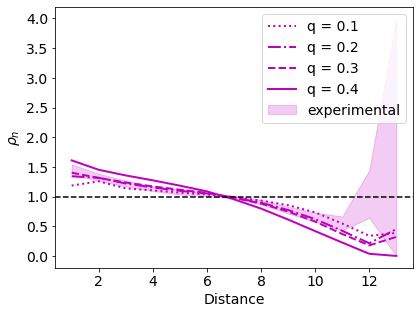

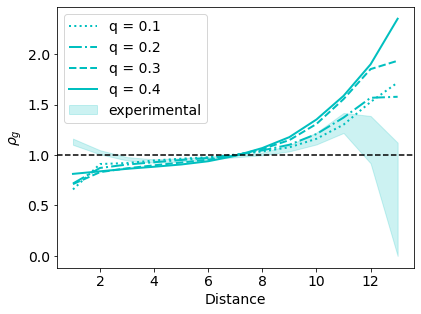

In [87]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from Functions import graphdistance3D, loadExpData, pc_bounds

def paircorrelation(N, G, GraphDist):
    x = np.zeros(len(N))
    x[N > G] = 1
    maxdist = int(np.max(GraphDist))
    ind = np.where(x==1)[0]
    if ind.size == 0:
        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = 0
            
    else:
        dist = GraphDist[ind].T[ind].T
        rho0 = sum(x)/len(x)
        rho1 = (sum(x)-1)/(len(x)-1)


        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = len(dist[dist==i])/len(GraphDist[GraphDist==i])/rho0/rho1

    return P

ID = 20
#q = 0.2

N, G, Pop, Pos = loadExpData(ID)
GraphDist = graphdistance3D(Pos)
PN_min, PN_max, PG_min, PG_max = pc_bounds(Pop, GraphDist, 1000)

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
for q in [0.1,0.2,0.3,0.4]:
    Data = pd.read_csv('C:/Users/sis85wc/Desktop/Cell-Differentiation/Results/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+'.csv')
    N = Data['Nanog']
    G = Data['Gata6']

    PN = paircorrelation(N, G, GraphDist)
    ranges = list(range(1,len(PN)+1))

    if q == 0.1:
        style = 'dotted'
    elif q == 0.2:
        style = 'dashdot'
    elif q == 0.3:
        style = 'dashed'
    else:
        style = 'solid'
        
    plt.plot(ranges, PN, 'm', lw=2, linestyle=style, label='q = '+str(q))
    plt.xlabel('Distance')
    plt.ylabel('$\\rho_n$')


plt.axhline(1, color='black', linestyle='dashed')
plt.fill_between(ranges, PN_min, PN_max, color='m', alpha=0.2, label='experimental')
plt.legend()
plt.savefig("Results/Publications/Pattern Formation/PCF NANOG ID = " + str(ID) + ".pdf")
plt.savefig("Results/Publications/Pattern Formation/PCF NANOG ID = " + str(ID) + ".png")

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
for q in [0.1,0.2,0.3,0.4]:
    Data = pd.read_csv('C:/Users/sis85wc/Desktop/Cell-Differentiation/Results/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+'.csv')
    N = Data['Nanog']
    G = Data['Gata6']

    PG = paircorrelation(G, N, GraphDist)
    ranges = list(range(1,len(PN)+1))

    if q == 0.1:
        style = 'dotted'
    elif q == 0.2:
        style = 'dashdot'
    elif q == 0.3:
        style = 'dashed'
    else:
        style = 'solid'
 
    plt.plot(ranges, PG, 'c', lw=2, linestyle=style, label='q = '+str(q))
    plt.xlabel('Distance')
    plt.ylabel('$\\rho_g$')

plt.axhline(1, color='black', linestyle='dashed')
plt.fill_between(ranges, PG_min, PG_max, color='c', alpha=0.2, label='experimental')
plt.legend()
plt.savefig("Results/Publications/Pattern Formation/PCF GATA6 ID = " + str(ID) + ".pdf")
plt.savefig("Results/Publications/Pattern Formation/PCF GATA6 ID = " + str(ID) + ".png")

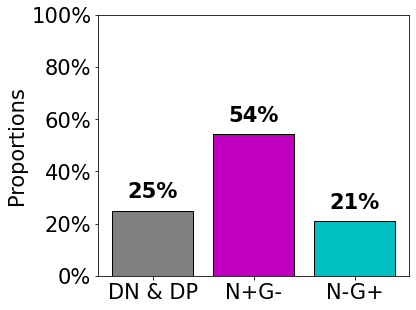

In [22]:
from ExpData import ExpData
import matplotlib.pyplot as plt

ID = 65 # 14, 29, 52, 62, 7, 65 (20, 68)

dat = ExpData('Data/includingSurfaceDistance/extendedRawDataICMOrganoids.csv')
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14*3/2)
dat.propPlot(ID)
plt.gcf().subplots_adjust(left=0.15*3/2)
plt.savefig("Results/Publications/Signal Range/Proportions ID = " + str(ID) + ".pdf", transparent=True)
plt.savefig("Results/Publications/Signal Range/Proportions ID = " + str(ID) + ".png", transparent=True)

In [16]:
dat.info(7)
print(1751 - 291 - 67)

Organoid 7 is 48h old
Organoid 7 consists of 1751 cells
Organoid 7 consists of 291 NANOG cells
Organoid 7 consists of 67 GATA6 cells
1393


Expected cell division time = 3.53156223514816
Expected number of Cells = 861.8099494976175
Organoid with 884 cells is ready!


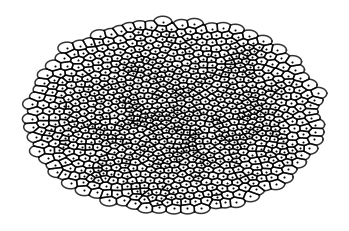

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from FVmesh import initializeFVmesh
from Organoid2D import initializeOrganoid
from Functions import coverPlot, saveData, paircorrelation, fate
from Model import rhs_activation
from Parameters import setParameters
from scipy.integrate import solve_ivp
import pandas as pd

DATA = pd.DataFrame()

Prm = setParameters()
Prm.nofCells_end = 1000
Organoid = initializeOrganoid(Prm, Transcription=False)
print("Organoid with " + str(len(Organoid.Pos)) + " cells is ready!")

FVmesh = initializeFVmesh(Organoid.Pos, Radius = np.ones(len(Organoid.Pos))*np.mean(Organoid.Radius))
FVmesh.plot()

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from FVmesh import initializeFVmesh
from Organoid2D import initializeOrganoid
from Functions import coverPlot, saveData, paircorrelation, fate
from Model import rhs_activation
from Parameters import setParameters
from scipy.integrate import solve_ivp
import pandas as pd

Prm = setParameters()
Prm.T = 240
Prm.nofSteps = 30000
t = np.linspace(0,Prm.T,Prm.nofSteps)

orgdata = pd.read_csv('ratio_size_comparison.csv')

for j in [-6.5,-7,-7.5]:
    DATA = pd.DataFrame()
    for i in range(max(orgdata['ID'])):

        data = orgdata[orgdata['ID']==i]
        Prm.eps_G = j
        x = data['x'].to_numpy()
        y = data['y'].to_numpy()
        Pos = np.concatenate(([x], [y]), axis=0).T
        FVmesh = initializeFVmesh(Pos, Radius = np.ones(len(Pos))*0.8)

        x0 = [Prm.r_N/Prm.gamma_N*3/4, Prm.r_G/Prm.gamma_G*3/4]
        xInit = np.append(np.random.normal(x0[0], x0[0]*0.01, FVmesh.nofCells),
                          np.random.normal(x0[1], x0[1]*0.01, FVmesh.nofCells))
        rhs = lambda t,x: rhs_activation(0, x, Prm, FVmesh)
        sol = np.empty([2*FVmesh.nofCells, Prm.nofSteps+1])
        sol[:,0] = xInit
        for k in range(Prm.nofSteps):
            sol[:,k+1] = sol[:,k] + (t[1]-t[0])*rhs(t[k], sol[:,k])

        N = sol[:FVmesh.nofCells,-1]
        G = sol[FVmesh.nofCells:,-1]
        F = fate(N,G)

        print('ID =', i, 'Total =', len(N), 'NANOG =', len(N[N>G]), 'GATA6 =', len(G[G>N]))

        df = pd.DataFrame()
        df['ID'] = i*np.ones(len(F), dtype=int)
        df['x'] = Pos[:,0]
        df['y'] = Pos[:,1]
        df['fate'] = F
        df['NANOG'] = N
        df['GATA6'] = G
        DATA = DATA.append(df)

    DATA.to_csv('tissue_size_comparison'+str(-j)+'.csv', index=False)

ID = 0 Total = 9 NANOG = 6 GATA6 = 3
ID = 1 Total = 9 NANOG = 7 GATA6 = 2
ID = 2 Total = 9 NANOG = 5 GATA6 = 4
ID = 3 Total = 9 NANOG = 6 GATA6 = 3
ID = 4 Total = 9 NANOG = 6 GATA6 = 3
ID = 5 Total = 10 NANOG = 7 GATA6 = 3
ID = 6 Total = 10 NANOG = 7 GATA6 = 3
ID = 7 Total = 10 NANOG = 7 GATA6 = 3
ID = 8 Total = 12 NANOG = 9 GATA6 = 3
ID = 9 Total = 12 NANOG = 7 GATA6 = 5
ID = 10 Total = 12 NANOG = 8 GATA6 = 4
ID = 11 Total = 12 NANOG = 8 GATA6 = 4
ID = 12 Total = 13 NANOG = 9 GATA6 = 4
ID = 13 Total = 15 NANOG = 10 GATA6 = 5
ID = 14 Total = 15 NANOG = 10 GATA6 = 5
ID = 15 Total = 17 NANOG = 12 GATA6 = 5
ID = 16 Total = 17 NANOG = 12 GATA6 = 5
ID = 17 Total = 18 NANOG = 12 GATA6 = 6
ID = 18 Total = 19 NANOG = 13 GATA6 = 6
ID = 19 Total = 19 NANOG = 13 GATA6 = 6
ID = 20 Total = 19 NANOG = 14 GATA6 = 5
ID = 21 Total = 20 NANOG = 15 GATA6 = 5
ID = 22 Total = 21 NANOG = 14 GATA6 = 7
ID = 23 Total = 21 NANOG = 14 GATA6 = 7
ID = 24 Total = 22 NANOG = 15 GATA6 = 7
ID = 25 Total = 24 NANOG = 1

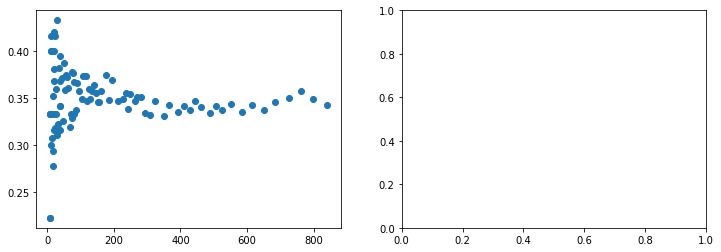

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from FVmesh import initializeFVmesh

DATA = pd.read_csv('tissue_size_comparison7.csv')

IDs = np.unique(DATA['ID'])
size = np.empty(len(IDs))
nofN = np.empty(len(IDs))
nofG = np.empty(len(IDs))
ratio = np.empty(len(IDs))
nofNeigh = np.zeros(len(IDs))
for i in IDs:
    org = DATA[DATA['ID'] == i]
    size[i] = len(org)
    nofN[i] = len(org[org['fate'] == 1])/len(org)
    nofG[i] = len(org[org['fate'] == 0])/len(org)
    ratio[i] = len(org[org['fate'] == 1])/len(org[org['fate'] == 0])
    
    x = org['x'].to_numpy()
    y = org['y'].to_numpy()

    Pos = np.concatenate(([x], [y]), axis=0).T
    #FVmesh = initializeFVmesh(Pos, Radius = 0.8*np.ones(len(Pos)))
    #for k in FVmesh.Neigh:
    #    nofNeigh[i] += len(k)/len(org)
    
    
def f(x, a, b):
    return a*x**(-1/2)+b

from scipy.optimize import curve_fit

plt.figure(figsize=(12,4))
plt.subplot(121)
popt, pcov = curve_fit(f, size, nofG)
plt.scatter(size, nofG)
#plt.plot(size, f(size, *popt), 'r')

plt.subplot(122)
#plt.scatter(size, nofNeigh)

(-9.872881952040313, 10.177833703173237, -9.74660368520022, 9.98459920107164)

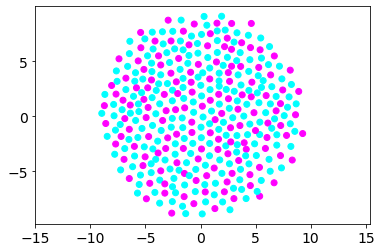

In [60]:
org = DATA[DATA['ID'] == 80]

F = org['fate'].to_numpy()
x = org['x'].to_numpy()
y = org['y'].to_numpy()

plt.scatter(x, y, c=F, cmap='cool')
plt.axis('equal')

[0.65134851] [5.01824884]


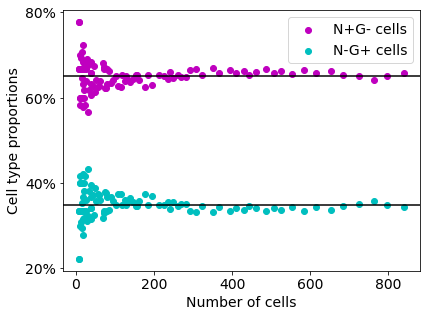

In [85]:
def f(x, a):
    return a*np.ones(len(x))

def g(x, a):
    return a*np.ones(len(x))

def h(x, a, b):
    return  a/g(x, *[-2*np.pi**(1/2)*1.67, 6]) + b

def k(x, a, b):
    return  a*g(x, *[-2*np.pi**(1/2)*1.67, 6]) + b
    

popt_f, pcov = curve_fit(f, size, nofN)
popt_g, pcov = curve_fit(g, size, nofNeigh)
print(popt_f, popt_g)

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
plt.scatter(size, nofN*100, color='m', label='N+G- cells')
plt.scatter(size, nofG*100, color='c', label='N-G+ cells')
#plt.plot(size, f(size, *popt_f)*100, 'k', lw=2, label='$\sigma_n(M)$, $\sigma_g(M)$')
#plt.plot(size, 1*100-f(size, *popt_f)*100, 'k', lw=2)
plt.axhline(np.mean(nofN)*100, color='k')
plt.axhline(np.mean(nofG)*100, color='k')
plt.xlabel('Number of cells')
plt.ylabel('Cell type proportions')
ticks = [20,40,60,80]
plt.yticks(ticks, [str(x)+'%' for x in ticks])
plt.legend()
plt.savefig("Results/Publications/Pattern Formation/proportions_size.pdf")
plt.savefig("Results/Publications/Pattern Formation/proportions_size.png")

## Different Ranges and Ratios

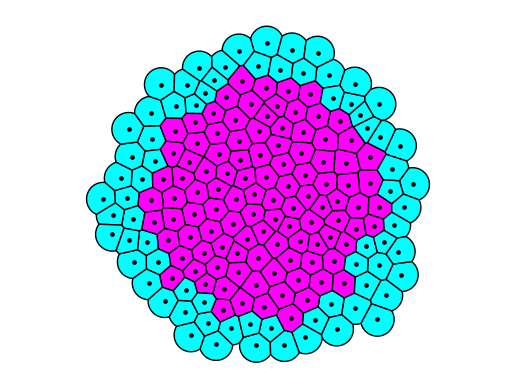

<Figure size 640x480 with 0 Axes>

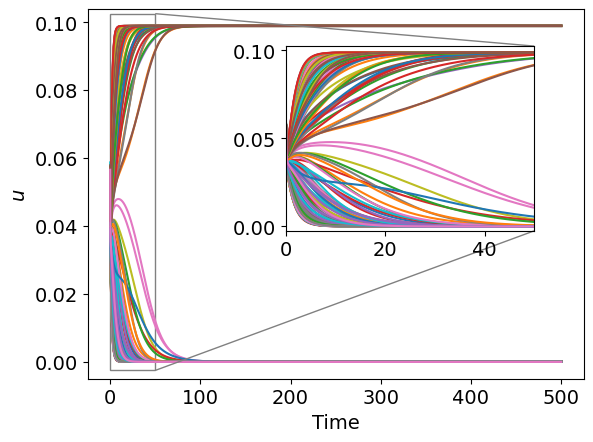

<Figure size 640x480 with 0 Axes>

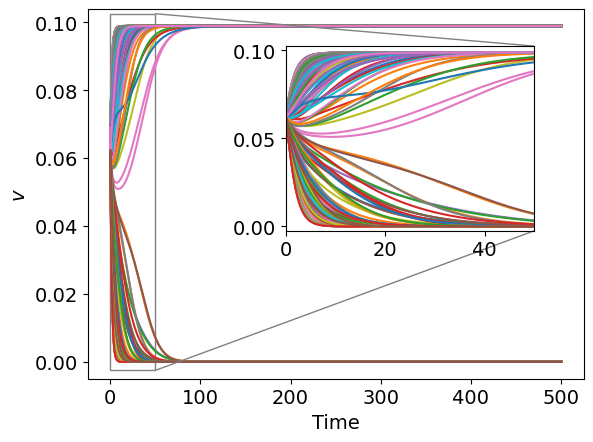

In [8]:
from Organoid import Organoid
import matplotlib.pyplot as plt

org = Organoid()
org.q = .9
org.eps_N = -7
org.signal = 'dispersion'
org.nofSteps = 10000
org.evolution(T=500, file = 'Organoid_mid.csv', ignore=['division', 'displacement'])
#org.saveData(directory = 'Results/Publications/Signal Range/eps_G='+str(-org.eps_G)+' q='+str(org.q)+'/')

if org.signal == 'neighbor':
    org.q='NN'
plt.figure(figsize=[6.4, 4.8])
org.cellPlot(org.G)
plt.savefig('Results/Publications/org_q='+str(org.q)+'.pdf', transparent=True)
plt.savefig('Results/Publications/org_q='+str(org.q)+'.png', transparent=True)

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
org.timePlot(TF='NANOG', zoom=[0,50])
plt.savefig('Results/Publications/u_q='+str(org.q)+'.pdf', transparent=True)
plt.savefig('Results/Publications/u_q='+str(org.q)+'.png', transparent=True)


plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
org.timePlot(TF='GATA6', zoom=[0,50])
plt.savefig('Results/Publications/v_q='+str(org.q)+'.pdf', transparent=True)
plt.savefig('Results/Publications/v_q='+str(org.q)+'.png', transparent=True)

C:\Users\schar\AppData\Local\Temp\ipykernel_10028\1693451545.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=[6.4, 4.8])


<Figure size 640x480 with 0 Axes>

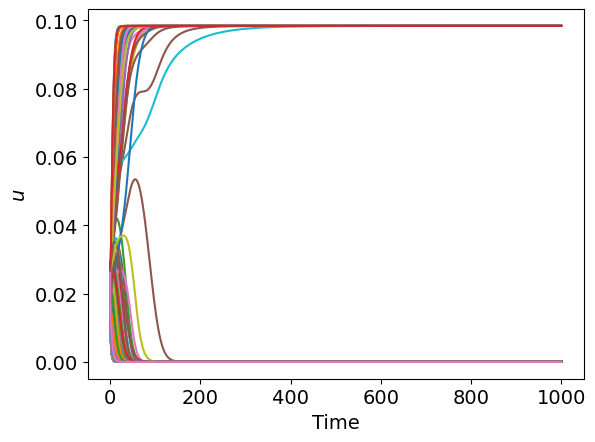

<Figure size 640x480 with 0 Axes>

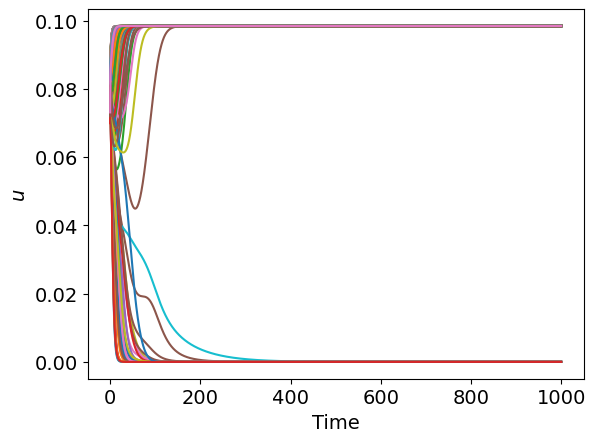

<Figure size 640x480 with 0 Axes>

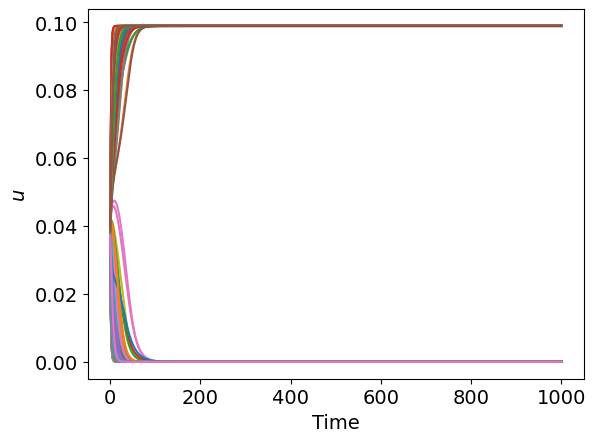

<Figure size 640x480 with 0 Axes>

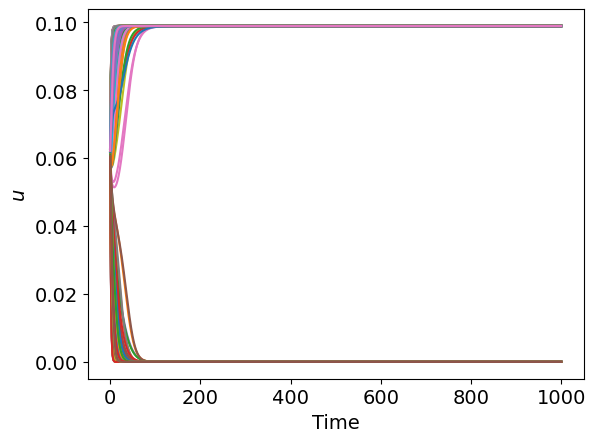

<Figure size 640x480 with 0 Axes>

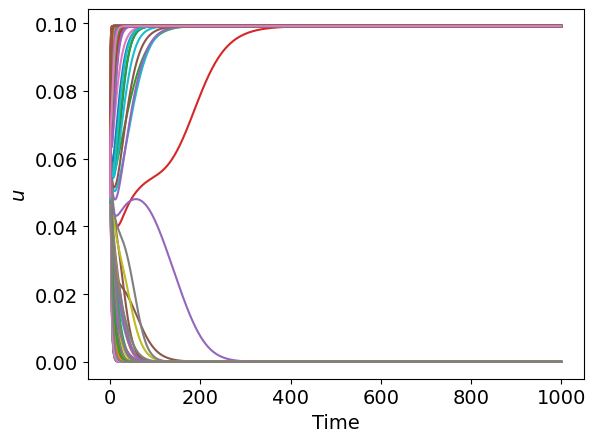

<Figure size 640x480 with 0 Axes>

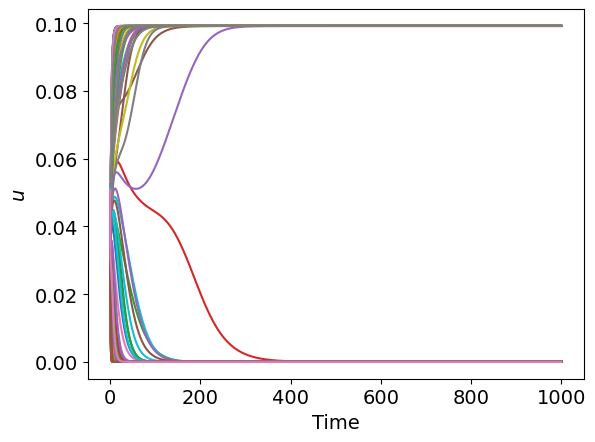

<Figure size 640x480 with 0 Axes>

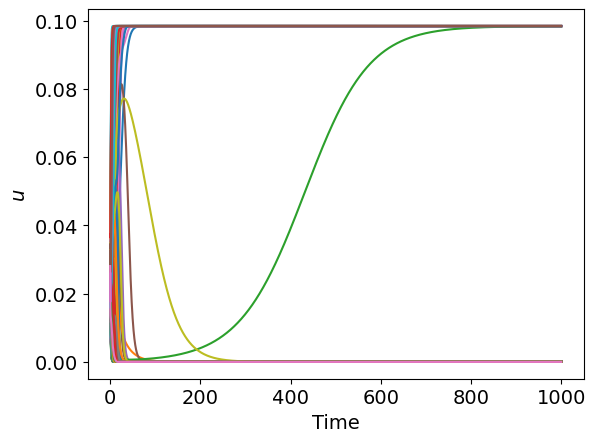

<Figure size 640x480 with 0 Axes>

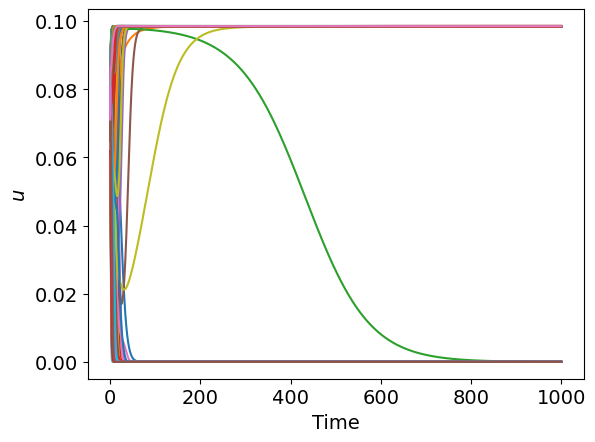

<Figure size 640x480 with 0 Axes>

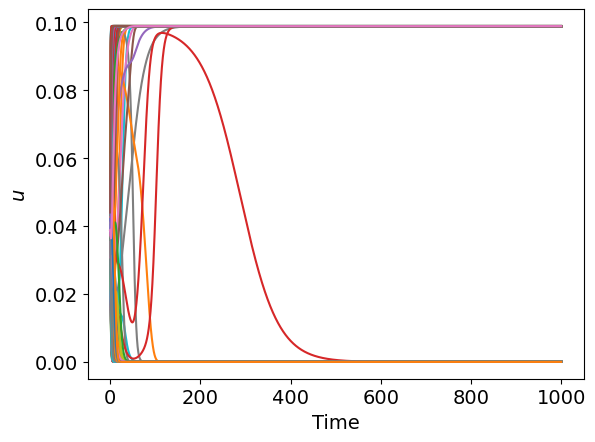

<Figure size 640x480 with 0 Axes>

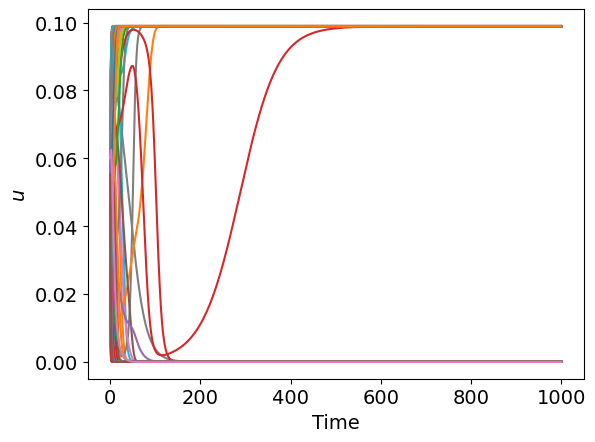

<Figure size 640x480 with 0 Axes>

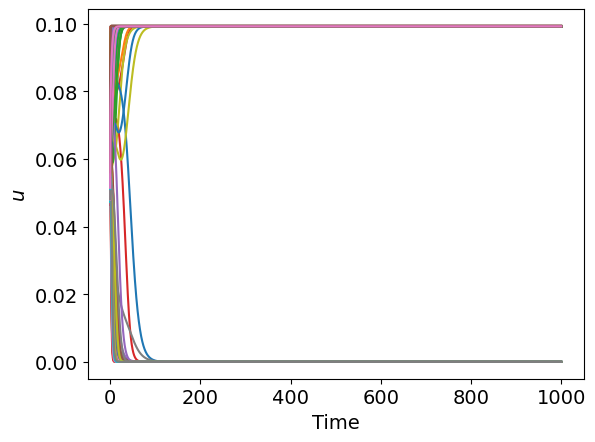

<Figure size 640x480 with 0 Axes>

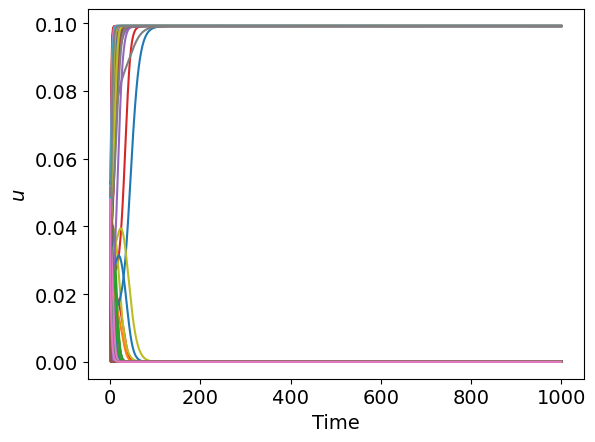

<Figure size 640x480 with 0 Axes>

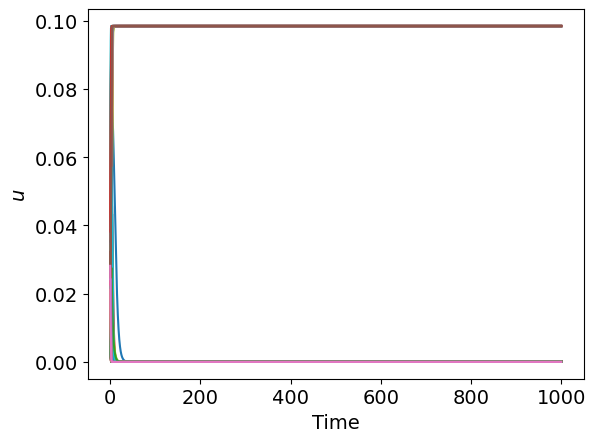

<Figure size 640x480 with 0 Axes>

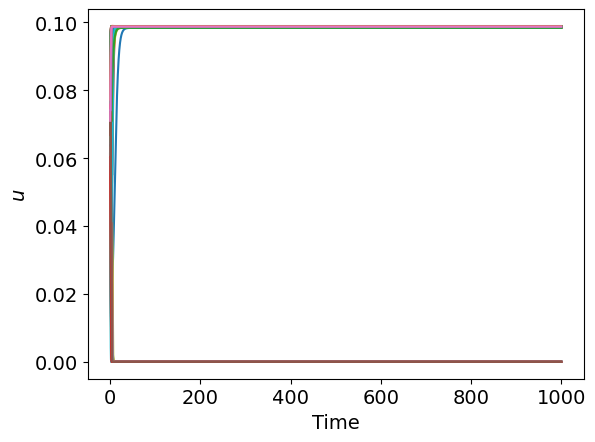

<Figure size 640x480 with 0 Axes>

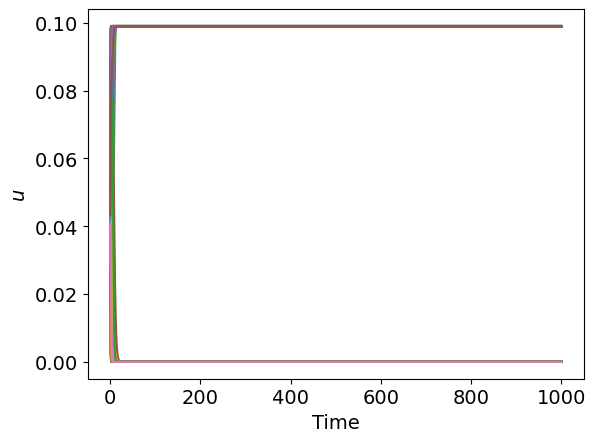

<Figure size 640x480 with 0 Axes>

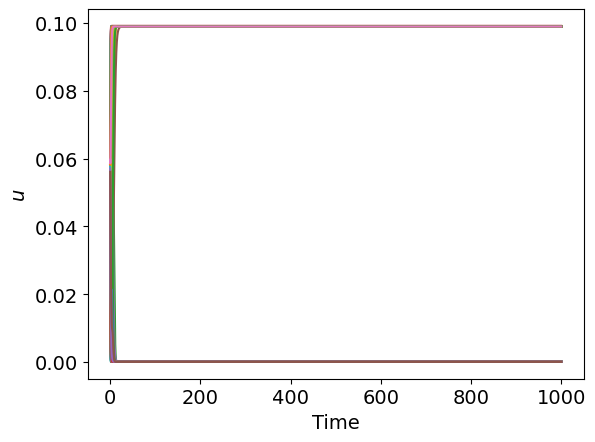

<Figure size 640x480 with 0 Axes>

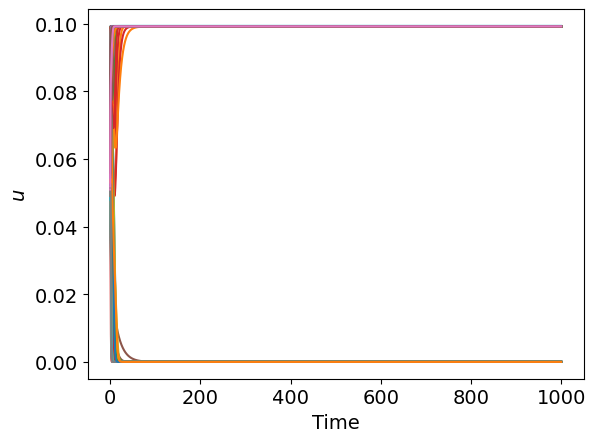

<Figure size 640x480 with 0 Axes>

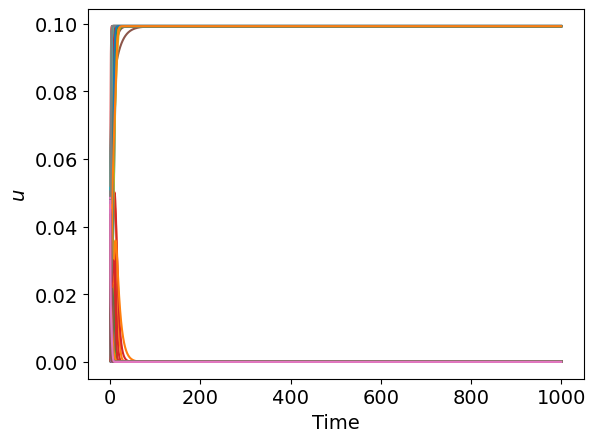

In [12]:
from Organoid import Organoid
import matplotlib.pyplot as plt


eps_N = [-6.5, -7, -7.5]
q = [.9, .5, .1]
# Plot the result
#plt.figure(figsize=(12,12))
for i in range(3):
    for j in range(3):
        #plt.subplot(3, 3, i*3 + j+1)
        org = Organoid()
        org.q = q[i]
        org.eps_N = eps_N[j]
        org.signal = 'dispersion'
        org.nofSteps = 10000
        org.evolution(T=1000, file = 'Organoid_mid.csv', ignore=['division', 'displacement'])
        #org.saveData(directory = 'Results/Publications/Signal Range/eps_G='+str(-org.eps_G)+' q='+str(org.q)+'/')
        plt.figure(figsize=[6.4, 4.8])
        plt.rc('font', size=14)
        org.timePlot(TF='NANOG')
        plt.savefig('Results/Publications/u_eps_u='+str(-org.eps_N)+' q='+str(org.q)+'.pdf', transparent=True)
        plt.savefig('Results/Publications/u_eps_u='+str(-org.eps_N)+' q='+str(org.q)+'.png', transparent=True)
        
        
        plt.figure(figsize=[6.4, 4.8])
        plt.rc('font', size=14)
        org.timePlot(TF='GATA6')
        plt.savefig('Results/Publications/v_eps_u='+str(-org.eps_N)+' q='+str(org.q)+'.pdf', transparent=True)
        plt.savefig('Results/Publications/v_eps_u='+str(-org.eps_N)+' q='+str(org.q)+'.png', transparent=True)

<Figure size 640x480 with 0 Axes>

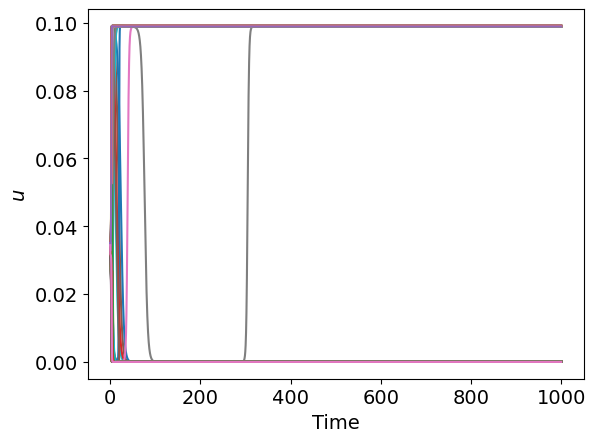

<Figure size 640x480 with 0 Axes>

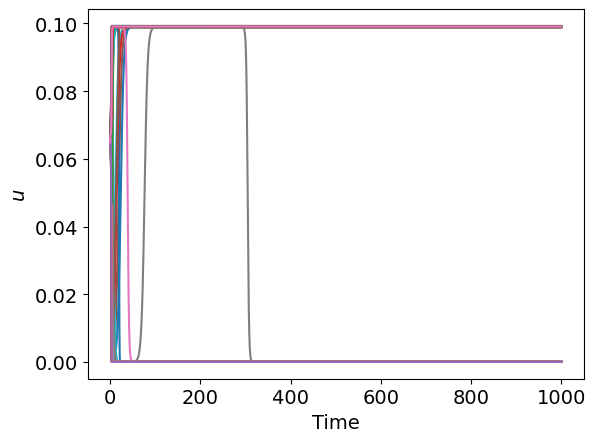

<Figure size 640x480 with 0 Axes>

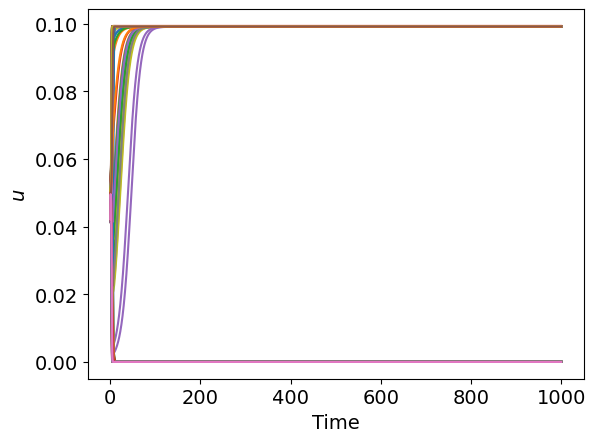

<Figure size 640x480 with 0 Axes>

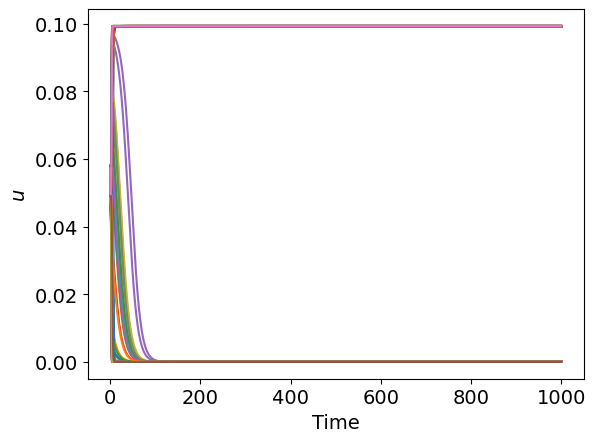

<Figure size 640x480 with 0 Axes>

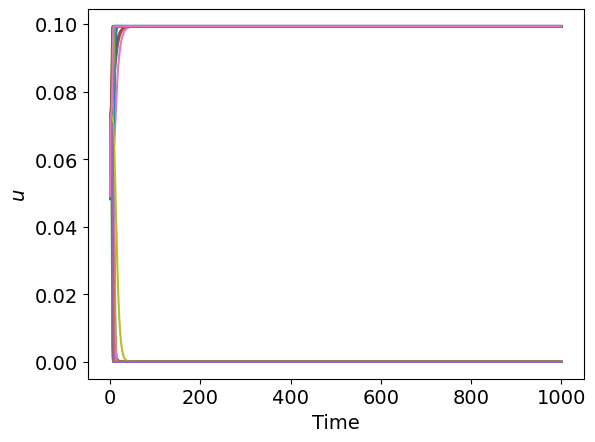

<Figure size 640x480 with 0 Axes>

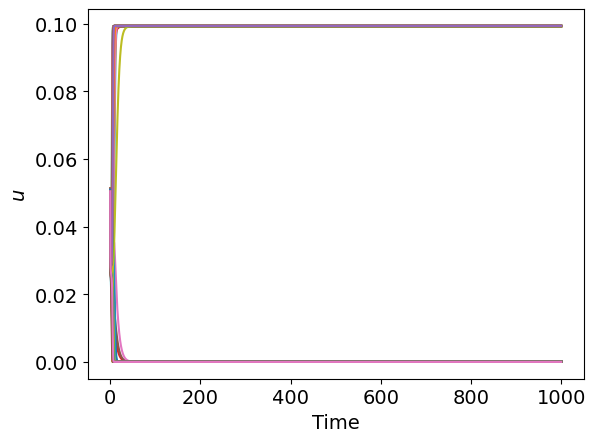

In [15]:
from Organoid import Organoid
import matplotlib.pyplot as plt


eps_N = [-7, -7.32, -7.6]
# Plot the result
#plt.figure(figsize=(12,12))
for j in range(3):
    #plt.subplot(3, 3, i*3 + j+1)
    org = Organoid()
    org.q = q[i]
    org.eps_N = eps_N[j]
    org.signal = 'neighbor'
    org.nofSteps = 10000
    org.evolution(T=1000, file = 'Organoid_mid.csv', ignore=['division', 'displacement'])
    #org.saveData(directory = 'Results/Publications/Signal Range/eps_G='+str(-org.eps_G)+' q='+str(org.q)+'/')
    plt.figure(figsize=[6.4, 4.8])
    plt.rc('font', size=14)
    org.timePlot(TF='NANOG')
    plt.savefig('Results/Publications/eps_G=u '+str(-org.eps_N)+'.pdf', transparent=True)
    plt.savefig('Results/Publications/eps_G=u '+str(-org.eps_N)+'.png', transparent=True)


    plt.figure(figsize=[6.4, 4.8])
    plt.rc('font', size=14)
    org.timePlot(TF='GATA6')
    plt.savefig('Results/Publications/eps_G=v '+str(-org.eps_N)+' q='+str(org.q)+'.pdf', transparent=True)
    plt.savefig('Results/Publications/eps_G=v '+str(-org.eps_N)+' q='+str(org.q)+'.png', transparent=True)

0.717767937343398


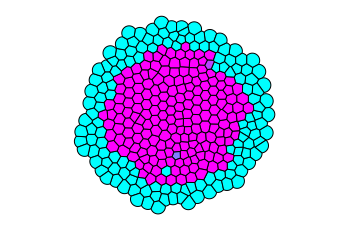

In [5]:
import numpy as np

org = Organoid()
org.q = .9
org.eps_G = -7
org.evolution(T=20, file = 'Organoid_large.csv', mode='transcription')
org.cellPlot(org.N, size=0)

# Weights
W = org.GraphDist
W[W > 1] = 0

# Fates
F = np.empty(org.N.shape)
F[org.N > org.G] = 1
F[org.N <= org.G] = 0

test = F - F.mean()
numerator = (test*test[:,None])*W
denominator = test**2

I = org.nofCells/np.sum(W)*np.sum(numerator)/np.sum(denominator)
print(I)

## Proportions

In [18]:
from Organoid2D import Organoid
import matplotlib.pyplot as plt
import numpy as np

org = Organoid()
s_max = org.r_G/org.gamma_G
upper_boundary = -org.eps_N + np.log(1 + np.exp(-org.eps_S-org.eps_NS)*s_max)
eps_G = np.linspace(6,upper_boundary,20)
q = 0.9

Ratio = np.empty(eps_G.shape)
for i in range(len(eps_G)):
    org = Organoid()
    org.eps_G = -eps_G[i]
    org.q = q
    org.evolution(T=40, file = 'Organoid_mid.csv', mode='transcription')
    F = [1 if org.N[i] >= org.G[i] else 0 for i in range(len(org.N))]

    Ratio[i] = np.sum(F)/org.nofCells

In [ ]:
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
plt.bar(eps_G, Ratio*100, width=0.06, color = 'm', edgecolor='k', alpha = 1, label='N+G-')
plt.bar(eps_G, (1-Ratio)*100, bottom=Ratio*100, width=0.06, color = 'c', edgecolor='k', alpha = 1, label='N-G+')
ticks = [0,20,40,60,80,100]
plt.yticks(ticks, [str(x)+'%' for x in ticks])
plt.xlabel('$-\Delta\epsilon_g$')
plt.ylabel('Proportions')
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.2)
plt.legend(framealpha=1)
plt.savefig('Results/Publications/Signal Range/Proportions q=0.9.pdf')
plt.savefig('Results/Publications/Signal Range/Proportions q=0.9.png')

## PCFs wrt Range

In [11]:
from Organoid2D import Organoid
import matplotlib.pyplot as plt
import numpy as np

def pcf(N, G, GraphDist):
    x = np.zeros(len(N))
    x[N > G] = 1
    maxdist = int(np.max(GraphDist))
    ind = np.where(x==1)[0]
    if ind.size == 0:
        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = 0
            
    else:
        dist = GraphDist[ind].T[ind].T
        rho0 = sum(x)/len(x)
        rho1 = (sum(x)-1)/(len(x)-1)


        P = np.empty(maxdist)
        for i in range(1,maxdist+1):
            P[i-1] = len(dist[dist==i])/len(GraphDist[GraphDist==i])/rho0/rho1

    return P

PN = []
PG = []
eps_N_list = []
ratio = 88/177
moran_list = []

for i in range(10):
    r = 1
    k = 0
    lower_boundary = -6
    upper_boundary = -7.86
    eps_N = (lower_boundary+upper_boundary)/2
    while r != ratio:
        org = Organoid()
        org.eps_N = eps_N
        org.signal = 'dispersion'
        org.q = 0.1*i
        org.evolution(T=100, file = 'Organoid_mid.csv', mode='transcription')
        org.moran()
        F = [1 if org.G[i] >= org.N[i] else 0 for i in range(len(org.N))]
        r = sum(F)/len(F)
        k += 1
        print('Iteration: '+str(k)+' Ratio: '+str(r)+' Current eps_N: '+str(eps_N))
        
        if r > ratio:
            lower_boundary = eps_N
        elif r <= ratio:
            upper_boundary = eps_N
            
        eps_N = (lower_boundary+upper_boundary)/2

    PN.append(pcf(org.G, org.N, org.GraphDist))
    PG.append(pcf(org.N, org.G, org.GraphDist))
    eps_N_list.append(eps_N)
    moran_list.append(org.Morans_I)

Iteration: 1 Ratio: 0.5028248587570622 Current eps_N: -6.93
Iteration: 2 Ratio: 0.2542372881355932 Current eps_N: -7.395
Iteration: 3 Ratio: 0.3615819209039548 Current eps_N: -7.1625
Iteration: 4 Ratio: 0.5028248587570622 Current eps_N: -7.04625
Iteration: 5 Ratio: 0.5028248587570622 Current eps_N: -7.104374999999999
Iteration: 6 Ratio: 0.3672316384180791 Current eps_N: -7.133437499999999
Iteration: 7 Ratio: 0.3615819209039548 Current eps_N: -7.118906249999999
Iteration: 8 Ratio: 0.3728813559322034 Current eps_N: -7.111640625
Iteration: 9 Ratio: 0.4519774011299435 Current eps_N: -7.1080078124999995
Iteration: 10 Ratio: 0.4689265536723164 Current eps_N: -7.10619140625
Iteration: 11 Ratio: 0.4971751412429379 Current eps_N: -7.1052832031249995
Iteration: 1 Ratio: 0.5084745762711864 Current eps_N: -6.93
Iteration: 2 Ratio: 0.2598870056497175 Current eps_N: -7.395
Iteration: 3 Ratio: 0.3785310734463277 Current eps_N: -7.1625
Iteration: 4 Ratio: 0.5028248587570622 Current eps_N: -7.04625
Ite

Parameters used: [-7.104829101562499, -7.06078125, -7.00265625, -7.00265625, -7.0208203125, -7.00265625, -7.01173828125, -7.024453125, -7.06078125, -7.16431640625]


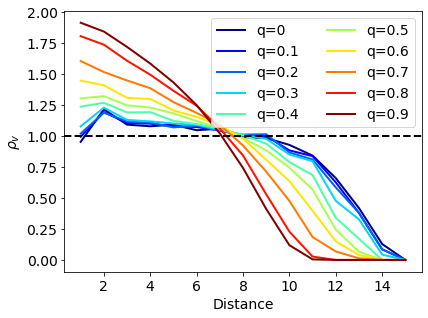

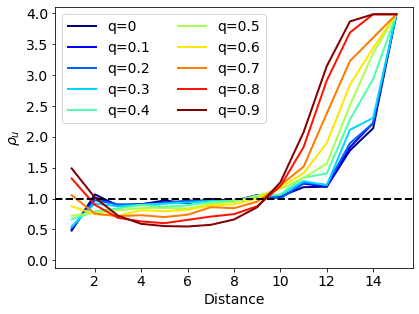

In [12]:
import matplotlib

cmap = matplotlib.cm.get_cmap('jet')
test = np.linspace(0,1,len(PN))
distances = [j for j in range(1,int(np.max(org.GraphDist))+1)]
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
q = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in range(len(PN)):
    rgba = cmap(test[i])
    
    plt.plot(distances,PN[i], color = rgba, lw=2, label='q='+str(q[i]))
    
plt.axhline(1, color='k', ls = 'dashed', lw = 2)
plt.legend(ncol=2)    
plt.xlabel('Distance')
plt.ylabel('$\\rho_v$')
#plt.ylim([0-0.12, max([np.max(PN), np.max(PG)])+0.12])
plt.savefig('Results/Publications/Signal Range/pair_correlation_v.pdf', transparent=True)
plt.savefig('Results/Publications/Signal Range/pair_correlation_v.png', transparent=True)

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
for i in range(len(PG)):
    rgba = cmap(test[i])
    
    plt.plot(distances,PG[i], color = rgba, lw=2, label='q='+str(q[i]))

plt.axhline(1, color='k', ls = 'dashed', lw = 2)
plt.legend(ncol=2)
plt.xlabel('Distance')
plt.ylabel('$\\rho_u$')
plt.ylim([0-0.12, max([np.max(PN), np.max(PG)])+0.12])
#sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=0, vmax=1))
#cbar = plt.colorbar(sm)
#cbar.ax.set_yticklabels([])
#cbar.set_label('$-\Delta\epsilon_g$')
plt.savefig('Results/Publications/Signal Range/pair_correlation_u.pdf', transparent=True)
plt.savefig('Results/Publications/Signal Range/pair_correlation_u.png', transparent=True)

print('Parameters used:', eps_N_list)

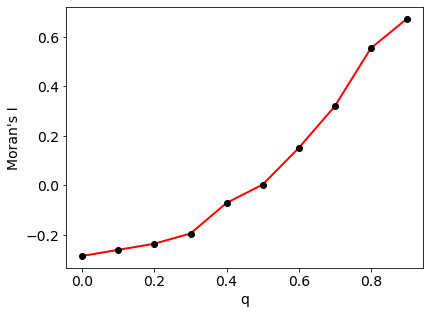

In [26]:
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
qs = [i*0.1 for i in range(10)]
plt.plot(qs, moran_list, color='r', lw=2)
plt.plot(qs, moran_list, 'o', color='k', lw=2)
plt.xlabel('q')
plt.ylabel('Moran\'s I')
plt.savefig('Results/Publications/Signal Range/morans_I.pdf', transparent=True)
plt.savefig('Results/Publications/Signal Range/morans_I.png', transparent=True)

## Organoid Data Application

In [10]:
# Save raw geometry of 3D organoids with cell radius as cutoff/2
from ExpData import ExpData
import numpy as np
import pandas as pd

dat = ExpData('Data/includingSurfaceDistance/extendedRawDataICMOrganoids.csv')
IDs = range(1, max(dat.id))

for ID in IDs:
    xyz = dat.pos[dat.id == ID]
    dat.graphdistance(ID)

    df1 = pd.DataFrame()
    df1['x-Position'] = xyz[:,0]
    df1['y-Position'] = xyz[:,1]
    df1['z-Position'] = xyz[:,2]
    df1['Radius'] = dat.cutoff/2*np.ones(len(xyz))
    df1.to_csv('Results/Publications/Signal Range/Simulation on Organoids/RawGeometry ID = '+str(ID)+'.csv', index=False)
    
    print('ID =', ID, 'Cutoff =', dat.cutoff)

ID = 1 Cutoff = 78.28519881356944
ID = 2 Cutoff = 77.40860585703781
ID = 3 Cutoff = 76.72474017976522
ID = 4 Cutoff = 70.49696492764156
ID = 5 Cutoff = 69.5487775391943
ID = 6 Cutoff = 72.69929324928721
ID = 7 Cutoff = 66.46358124087436
ID = 8 Cutoff = 71.73785597833984
ID = 9 Cutoff = 75.6212818550751
ID = 10 Cutoff = 78.92796717480849
ID = 11 Cutoff = 73.23233825071148
ID = 12 Cutoff = 78.99074368017875
ID = 13 Cutoff = 75.4134988858368
ID = 14 Cutoff = 62.269270501061044
ID = 15 Cutoff = 68.77688717615429
ID = 16 Cutoff = 70.78407916324252
ID = 17 Cutoff = 72.21291128111832
ID = 18 Cutoff = 67.59229943807313
ID = 19 Cutoff = 69.56666759693694
ID = 20 Cutoff = 69.58719781783357
ID = 21 Cutoff = 65.3065971711472
ID = 22 Cutoff = 69.668187527402
ID = 23 Cutoff = 68.63245762685867
ID = 24 Cutoff = 91.54915528400628
ID = 25 Cutoff = 87.61245222654445
ID = 26 Cutoff = 73.46468420833142
ID = 27 Cutoff = 79.042783150048
ID = 28 Cutoff = 82.9914366571044
ID = 29 Cutoff = 67.08335722829901
ID

In [9]:
#### import numpy as np
import pandas as pd
from Organoid3D import Organoid
from scipy.spatial.distance import cdist


#### Import Geometry ####
DATA = pd.read_csv('Data/includingSurfaceDistance/extendedRawDataICMOrganoids.csv')

IDs = [7, 65] #[14, 20, 29, 52, 62, 68]
Qs = [0.2, 0.4, 0.6, 0.8]
for ID in IDs:
    for Q in Qs:
        q = Q

        nofCalc = 0
        r = 0
        Data = DATA[DATA['OrganoidID'] == ID]
        ratio = len(Data[Data['Population']=='N+G-'])/len(Data[Data['Population']=='N-G+'])
        offset = 0.1
        lower_boundary = -6
        upper_boundary = -7.86
        eps_G = -6.4#(lower_boundary+upper_boundary)/2
        while (r < ratio - ratio*offset or r > ratio + ratio*offset) and nofCalc < 10:
            org = Organoid()
            org.eps_G = eps_G
            org.q = q
            org.nofSteps = 3000
            org.evolution(T=40, file = 'Results/Publications/Signal Range/Simulation on Organoids/RawGeometry ID = '+str(ID)+'.csv',
                          mode='transcription')
            F = [1 if org.N[i] >= org.G[i] else 0 for i in range(len(org.N))]
            r = sum(F)/(len(F)-sum(F))
            nofCalc += 1
            print('Iteration: '+str(nofCalc)+' Current: '+str(r)+' Aim: '+str(ratio)+' Current eps_G: '+str(eps_G))

            if r > ratio:
                lower_boundary = eps_G
            elif r <= ratio:
                upper_boundary = eps_G

            eps_G0 = eps_G
            eps_G = (lower_boundary+upper_boundary)/2

        df = pd.DataFrame()
        df['x-Position'] = org.xyz[:,0]
        df['y-Position'] = org.xyz[:,1]
        df['z-Position'] = org.xyz[:,2]
        df['Radius'] = org.r
        df['Nanog'] = org.N
        df['Gata6'] = org.G
        df['eps_G'] = eps_G0

        df.to_csv('Results/Publications/Signal Range/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+' mean+2std.csv', index=False)
        print('Finished!!!')

Iteration: 1 Current: 3.5837696335078535 Aim: 4.343283582089552 Current eps_G: -6.4
Iteration: 2 Current: 6.852017937219731 Aim: 4.343283582089552 Current eps_G: -6.2
Iteration: 3 Current: 4.8561872909699 Aim: 4.343283582089552 Current eps_G: -6.300000000000001
Iteration: 4 Current: 4.15 Aim: 4.343283582089552 Current eps_G: -6.3500000000000005
Finished!!!
Iteration: 1 Current: 4.15 Aim: 4.343283582089552 Current eps_G: -6.4
Finished!!!
Iteration: 1 Current: 4.759868421052632 Aim: 4.343283582089552 Current eps_G: -6.4
Finished!!!
Iteration: 1 Current: 6.089068825910931 Aim: 4.343283582089552 Current eps_G: -6.4
Iteration: 2 Current: 0.8373557187827911 Aim: 4.343283582089552 Current eps_G: -7.130000000000001
Iteration: 3 Current: 2.2010968921389398 Aim: 4.343283582089552 Current eps_G: -6.765000000000001
Iteration: 4 Current: 3.5718015665796345 Aim: 4.343283582089552 Current eps_G: -6.5825000000000005
Iteration: 5 Current: 4.576433121019108 Aim: 4.343283582089552 Current eps_G: -6.49125

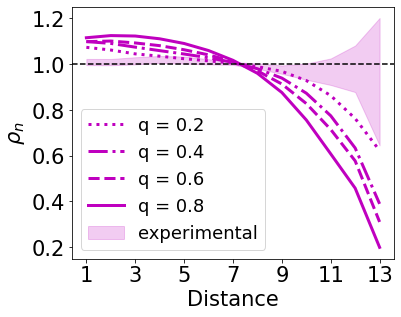

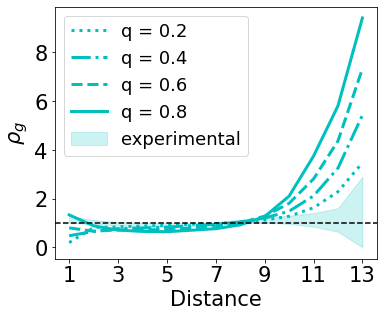

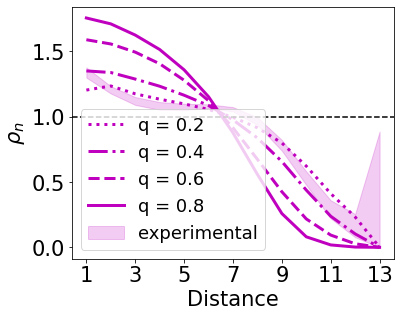

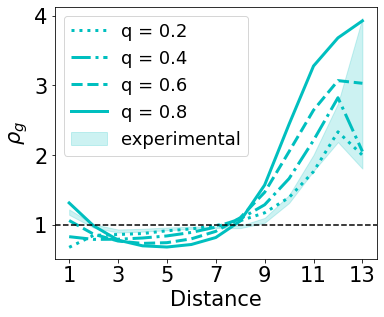

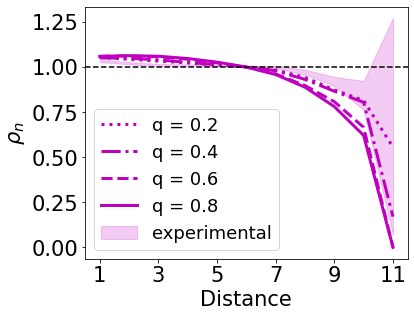

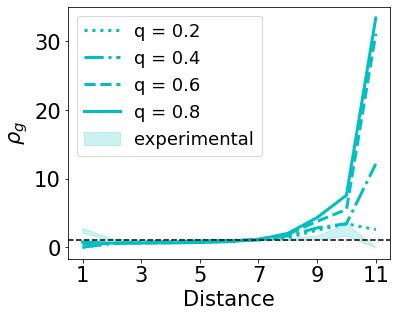

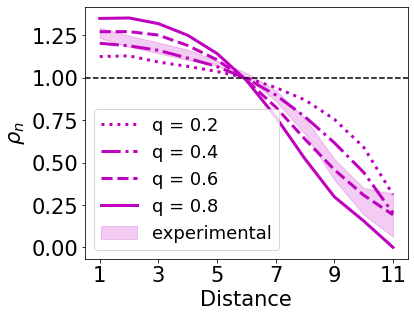

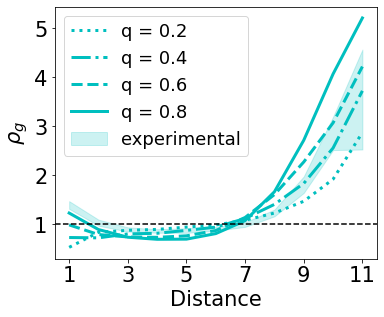

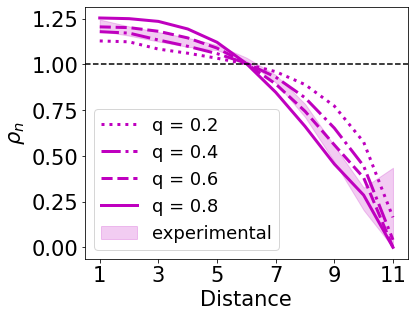

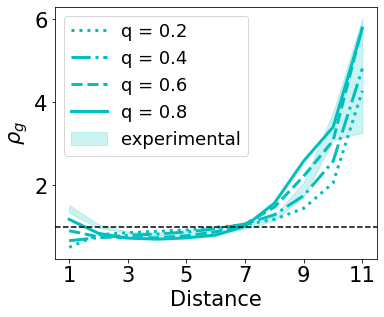

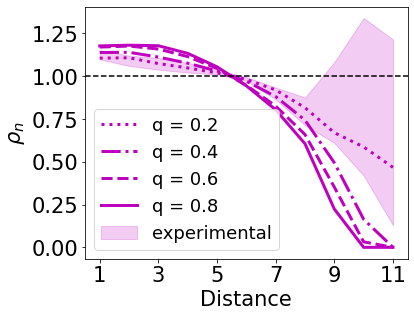

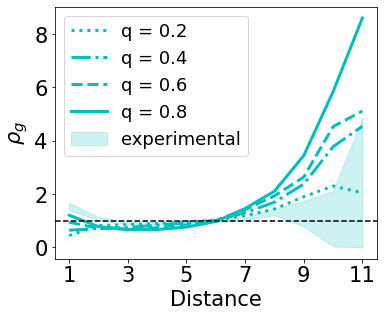

In [97]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from Functions import graphdistance3D, loadExpData, pc_bounds
from ExpData import ExpData
from Organoid3D import Organoid

IDs = [7, 14, 29, 52, 62, 65] #[20, 68]
Q = [0.2,0.4,0.6,0.8]
styles = ['dotted', 'dashdot', 'dashed', 'solid']

dat = ExpData('Data/includingSurfaceDistance/extendedRawDataICMOrganoids.csv')

for ID in IDs:
    dat.pcf_bounds(ID, 1000, plot = False)
    
    # NANOG
    plt.figure(figsize=[6.4, 4.8])
    plt.rc('font', size=14*1.5)
    for i, q in enumerate(Q):

        org = Organoid()
        org.initialConditions('Results/Publications/Signal Range/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+' mean+2std.csv')
        Data = pd.read_csv('Results/Publications/Signal Range/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+' mean+2std.csv')
        org.N = Data['Nanog'].to_numpy()
        org.G = Data['Gata6'].to_numpy()
        org.GraphDist = dat.GraphDist[ID]
        org.pcf(plot = False)

        ranges = list(range(1,len(org.pcf_N)+1))
        plt.plot(ranges, org.pcf_N, 'm', lw=3, linestyle=styles[i], label='q = '+str(q))
        plt.xlabel('Distance')
        plt.ylabel('$\\rho_n$')

    ranges = list(range(1,len(org.pcf_N)+1))
    plt.axhline(1, color='black', linestyle='dashed')
    plt.fill_between(ranges, dat.pcf[ID][0], dat.pcf[ID][2], color='m', alpha=0.2, label='experimental')
    plt.legend(fontsize=18)
    xticks = list(range(1,int(np.max(org.GraphDist))+1, 2))
    plt.xticks(xticks)
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.gcf().subplots_adjust(left=0.2)
    plt.savefig("Results/Publications/Signal Range/PCF NANOG ID = " + str(ID) + ".pdf", transparent=True)
    plt.savefig("Results/Publications/Signal Range/PCF NANOG ID = " + str(ID) + ".png", transparent=True)

    # GATA6
    plt.figure(figsize=[6.4, 4.8])
    plt.rc('font', size=14*1.5)
    for i, q in enumerate(Q):

        org = Organoid()
        org.initialConditions('Results/Publications/Signal Range/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+' mean+2std.csv')
        Data = pd.read_csv('Results/Publications/Signal Range/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+' mean+2std.csv')
        org.N = Data['Nanog'].to_numpy()
        org.G = Data['Gata6'].to_numpy()
        org.GraphDist = dat.GraphDist[ID]
        org.pcf(plot = False)

        ranges = list(range(1,len(org.pcf_G)+1))
        plt.plot(ranges, org.pcf_G, 'c', lw=3, linestyle=styles[i], label='q = '+str(q))
        plt.xlabel('Distance')
        plt.ylabel('$\\rho_g$')

    ranges = list(range(1,len(org.pcf_G)+1))
    plt.axhline(1, color='black', linestyle='dashed')
    plt.fill_between(ranges, dat.pcf[ID][3], dat.pcf[ID][5], color='c', alpha=0.2, label='experimental')
    plt.legend(fontsize=18)
    xticks = list(range(1,int(np.max(org.GraphDist))+1, 2))
    plt.xticks(xticks)
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.gcf().subplots_adjust(left=0.2)
    plt.savefig("Results/Publications/Signal Range/PCF GATA6 ID = " + str(ID) + ".pdf", transparent=True)
    plt.savefig("Results/Publications/Signal Range/PCF GATA6 ID = " + str(ID) + ".png", transparent=True)

Organoid 62 is 48h old
Organoid 62 consists of 1051 cells
Organoid 62 consists of 546 NANOG cells
Organoid 62 consists of 276 GATA6 cells
Organoid 62 has a NANOG:GATA6 ratio of 1.9782608695652173


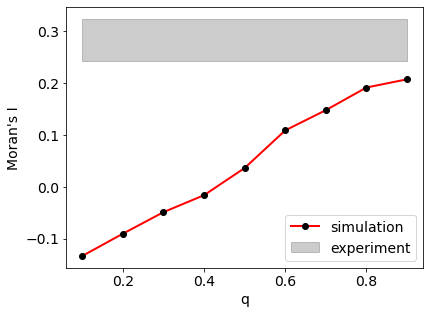

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from Functions import graphdistance3D, loadExpData, moran_bounds

def moran(x, GraphDist):
    
    W = np.copy(GraphDist)
    W[W > 1] = 0
    y = x - x.mean()

    numerator = np.dot(y, np.dot(W, y))
    denominator = np.sum(y**2)

    return len(x)/np.sum(W)*numerator/denominator


ID = 62 #[14, 20, 29, 52, 62, 68]

N, G, Pop, Pos = loadExpData(ID)
GraphDist = graphdistance3D(Pos, cutoff=85)
I_min, I_max = moran_bounds(Pop, GraphDist, 1000)

plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)
Qs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
Is = []
for q in Qs:
    Data = pd.read_csv('Results/Publications/Signal Range/Simulation on Organoids/Organoid '+str(ID)+' q='+str(q)+' 85.csv')
    N = Data['Nanog']
    G = Data['Gata6']
    F = np.zeros(len(N))
    F[N > G] = 1
    
    Is.append(moran(F, GraphDist))
        
plt.plot(Qs, Is, 'ro-', mfc='k', lw=2, mec='k', label='simulation')
plt.fill_between(Qs, [I_min]*len(Qs), [I_max]*len(Qs), color='k', alpha=0.2, label='experiment')
plt.xlabel('q')
plt.ylabel('Moran\'s I')
plt.legend(loc='lower right')
plt.savefig("Results/Publications/Signal Range/Moran ID = " + str(ID) + ".pdf", transparent=True)
plt.savefig("Results/Publications/Signal Range/Moran ID = " + str(ID) + ".png", transparent=True)

1.) Moran's I = -0.024504231400783127
2.) Moran's I = 0.6405325443786983


(-0.047856482107173005,
 1.0444486265010104,
 -0.03680711558035655,
 1.0029954844857163)

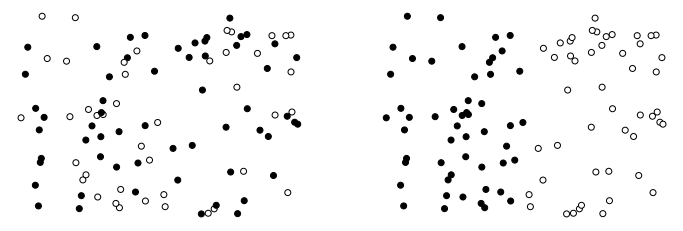

In [67]:
import networkx as nx
import itertools
import numpy as np
from scipy.spatial import Delaunay
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

def graphdistance(pos, cutoff = 90):
    Gr = nx.Graph()
    dist = cdist(pos, pos)
    tri = Delaunay(pos)

    for nodes in tri.simplices:
        for path in list(itertools.combinations(nodes, 2)):
            if dist[path[0],path[1]] < cutoff:
                nx.add_path(Gr, path)

    dist_dict = dict(nx.all_pairs_dijkstra_path_length(Gr))
    GraphDist = np.empty([len(pos), len(pos)])
    for i in range(len(pos)):
        for j in range(len(pos)):
            GraphDist[i,j] = dist_dict[i][j]
        
    return GraphDist
 
def moran(x, W):
    
    W[W > 1] = 0
    y = x - x.mean()

    numerator = np.dot(y, np.dot(W, y))
    denominator = np.sum(y**2)

    return len(x)/np.sum(W)*numerator/denominator

# random Daten, ersetzen durch Organoiddaten
pos = np.random.random([100,3])          # x,y,z Koordinaten

# Bsp. 1: Zellschicksal random
fate1 = np.round(np.random.random(100))

# Bsp. 2: Zellschicksal sortiert
fate2 = np.zeros(100)
fate2[pos[:,0] > (max(pos[:,0])-min(pos[:,0]))/2] = 1    # Zellschicksal sortiert. Links 0 rechts 1

W = graphdistance(pos)
print('1.) Moran\'s I =', moran(fate1, W))
print('2.) Moran\'s I =', moran(fate2, W))
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(pos[:,0], pos[:,1], c=fate1, edgecolor='k', cmap='gray')
plt.axis('off')
plt.subplot(122)
plt.scatter(pos[:,0], pos[:,1], c=fate2, edgecolor='k', cmap='gray')
plt.axis('off')

Organoid 14 is 48h old
Organoid 14 consists of 1531 cells
Organoid 14 consists of 579 NANOG cells
Organoid 14 consists of 608 GATA6 cells
Organoid 14 has a NANOG:GATA6 ratio of 0.9523026315789473


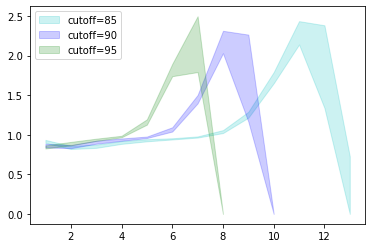

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from Functions import loadExpData, pc_bounds
from scipy.spatial.distance import cdist

ID = 14 #[14, 20, 29, 52, 62, 68]

N, G, Pop, Pos = loadExpData(ID)
dist = cdist(Pos, Pos)
GraphDist1 = np.floor(dist/30)
PN_min1, PN_max1, PG_min1, PG_max1 = pc_bounds(Pop, GraphDist1, 100)
GraphDist2 = np.floor(dist/40)
PN_min2, PN_max2, PG_min2, PG_max2 = pc_bounds(Pop, GraphDist2, 100)
GraphDist3 = np.floor(dist/50)
PN_min3, PN_max3, PG_min3, PG_max3 = pc_bounds(Pop, GraphDist3, 100)

ranges1 = list(range(1,len(PN_min1)+1))
ranges2 = list(range(1,len(PN_min2)+1))
ranges3 = list(range(1,len(PN_min3)+1))
plt.fill_between(ranges1, PG_min1, PG_max1, color='c', alpha=0.2, label='cutoff=85')
plt.fill_between(ranges2, PG_min2, PG_max2, color='b', alpha=0.2, label='cutoff=90')
plt.fill_between(ranges3, PG_min3, PG_max3, color='g', alpha=0.2, label='cutoff=95')
plt.legend(loc='upper left')

## Cell number

In [1]:
from Organoid2D import Organoid
import matplotlib.pyplot as plt
import numpy as np

q = [.9, .5, .1]
# Plot the result
fig = plt.figure(figsize=[6.4, 4.8])
for i in range(3):
    #plt.subplot(3, 3, i*3 + j+1)
    org_s = Organoid()
    org_m = Organoid()
    org_l = Organoid()
    org_s.q = q[i]
    org_m.q = q[i]
    org_l.q = q[i]
    org_s.evolution(T=100, file = 'Organoid_small.csv', mode='transcription')
    org_m.evolution(T=100, file = 'Organoid_mid.csv', mode='transcription')
    org_l.evolution(T=100, file = 'Organoid_large.csv', mode='transcription')
    
    size = 1000/len(org_l.xy)
    #org.saveData(directory = 'Results/Publications/Signal Range/'+size[j]+' q='+str(org.q)+'/')
    lims = np.max(abs(org_l.xy))+1.5
    plt.figure(figsize=[6.4, 4.8])
    org_s.cellPlot(org_s.N, size=size)
    plt.xlim([-lims, lims])
    plt.ylim([-lims, lims])
    plt.gca().set_adjustable("box")
    plt.savefig('Results/Publications/Signal Range/Cell number variation/small q='+str(org_s.q)+'.png', transparent=True)
    plt.savefig('Results/Publications/Signal Range/Cell number variation/small q='+str(org_s.q)+'.pdf', transparent=True)
    
    plt.figure(figsize=[6.4, 4.8])
    org_m.cellPlot(org_m.N, size=size)
    plt.xlim([-lims, lims])
    plt.ylim([-lims, lims])
    plt.gca().set_adjustable("box")
    plt.savefig('Results/Publications/Signal Range/Cell number variation/medium q='+str(org_m.q)+'.png', transparent=True)
    plt.savefig('Results/Publications/Signal Range/Cell number variation/medium q='+str(org_m.q)+'.pdf', transparent=True)
    
    plt.figure(figsize=[6.4, 4.8])
    org_l.cellPlot(org_l.N, size=size)
    plt.xlim([-lims, lims])
    plt.ylim([-lims, lims])
    plt.gca().set_adjustable("box")
    plt.savefig('Results/Publications/Signal Range/Cell number variation/large q='+str(org_l.q)+'.png', transparent=True)
    plt.savefig('Results/Publications/Signal Range/Cell number variation/large q='+str(org_l.q)+'.pdf', transparent=True)
    
    plt.figure(figsize=[6.4, 4.8])
    org_l.pcf(ls='solid', lw=3, font_size=14*1.5)
    org_s.pcf(ls='dotted', lw=3, font_size=14*1.5)
    org_m.pcf(ls='dashed', lw=3, font_size=14*1.5)
    plt.legend(['N+G-', 'N-G+'], fontsize=18)
    plt.gcf().subplots_adjust(bottom=0.15)
    plt.gcf().subplots_adjust(left=0.2)
    
    plt.savefig('Results/Publications/Signal Range/Cell number variation/pcf q='+str(org_s.q)+'.png', transparent=True)
    plt.savefig('Results/Publications/Signal Range/Cell number variation/pcf q='+str(org_s.q)+'.pdf', transparent=True)

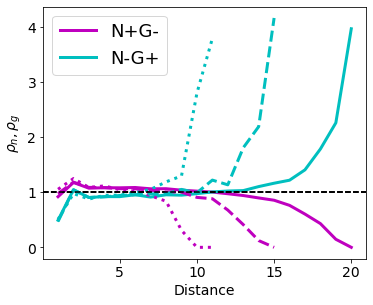

In [12]:
plt.rc('font', size=14*1.5)
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14*1.5)
org_l.pcf(ls='solid', lw=3, legend=True)
org_s.pcf(ls='dotted', lw=3, legend=False)
org_m.pcf(ls='dashed', lw=3, legend=False)
plt.rc('font', size=14*1.5)
plt.legend(['N+G-', 'N-G+'], fontsize=18)
plt.gcf().subplots_adjust(bottom=0.15)
plt.gcf().subplots_adjust(left=0.2)

## Cell division characterization

In [1]:
#from Organoid2D import Organoid
from Organoid3D import Organoid
import matplotlib.pyplot as plt
import numpy as np


T = 24
N = 10
q = [i*0.1 for i in range(10)]

Morans_Div = np.empty([len(q), N])
Morans_Sta = np.empty([len(q), N])
for i in range(len(q)):
    for j in range(N):
        print('Iteration:', i, j)      
        org = Organoid()
        org.q = q[i]
        
        # Division
        org.evolution(T=T)
        org.moran()
        Morans_Div[i,j] = org.Morans_I

        # Static
        N0 = org.r_N/org.gamma_N*3/4
        G0 = org.r_N/org.gamma_N*3/4
        org.u = np.append(np.random.normal(N0, N0*0.01, org.nofCells),
                          np.random.normal(G0, G0*0.01, org.nofCells))
        org.N = org.u[:org.nofCells]
        org.G = org.u[org.nofCells:]
        org.evolution(T=T, mode='transcription')
        org.moran()
        Morans_Sta[i,j] = org.Morans_I
    
plt.scatter(q, Morans_Div.mean(axis=1))
plt.scatter(q, Morans_Sta.mean(axis=1))

Iteration: 0 0
Iteration: 0 1
Iteration: 0 2
Iteration: 0 3
Iteration: 0 4
Iteration: 0 5
Iteration: 0 6
Iteration: 0 7
Iteration: 0 8
Iteration: 0 9
Iteration: 1 0
Iteration: 1 1
Iteration: 1 2
Iteration: 1 3
Iteration: 1 4
Iteration: 1 5
Iteration: 1 6
Iteration: 1 7
Iteration: 1 8
Iteration: 1 9
Iteration: 2 0
Iteration: 2 1
Iteration: 2 2
Iteration: 2 3
Iteration: 2 4
Iteration: 2 5
Iteration: 2 6
Iteration: 2 7
Iteration: 2 8
Iteration: 2 9
Iteration: 3 0
Iteration: 3 1
Iteration: 3 2
Iteration: 3 3
Iteration: 3 4
Iteration: 3 5
Iteration: 3 6
Iteration: 3 7
Iteration: 3 8
Iteration: 3 9
Iteration: 4 0
Iteration: 4 1
Iteration: 4 2
Iteration: 4 3
Iteration: 4 4
Iteration: 4 5
Iteration: 4 6
Iteration: 4 7
Iteration: 4 8
Iteration: 4 9
Iteration: 5 0
Iteration: 5 1
Iteration: 5 2
Iteration: 5 3
Iteration: 5 4
Iteration: 5 5
Iteration: 5 6
Iteration: 5 7
Iteration: 5 8
Iteration: 5 9
Iteration: 6 0
Iteration: 6 1
Iteration: 6 2
Iteration: 6 3
Iteration: 6 4
Iteration: 6 5
Iteration:

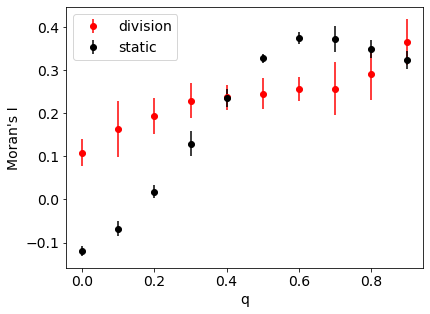

In [2]:
plt.figure(figsize=[6.4, 4.8])
plt.rc('font', size=14)

plt.errorbar(q, Morans_Div.mean(axis=1), Morans_Div.std(axis=1), linestyle='None', marker='o', color='r', label='division')
plt.errorbar(q, Morans_Sta.mean(axis=1), Morans_Sta.std(axis=1), linestyle='None', marker='o', color='k', label='static')
plt.legend()
plt.xlabel('q')
plt.ylabel('Moran\'s I')
plt.savefig('morans 3D.png', transparent=True)
plt.savefig('morans 3D.pdf', transparent=True)

In [1]:
from ExpData import ExpData
import matplotlib.pyplot as plt
import numpy as np

dat = ExpData('Data/includingSurfaceDistance/extendedRawDataICMOrganoids.csv')
maxID = np.max(dat.id)

for ID in range(1, maxID+1):
    print(ID, 'of', maxID)
    plt.figure(figsize=[6.4, 4.8])
    dat.pcf_bounds(ID, 100)
    plt.title('ID = ' + str(ID) + ', Stage = ' + dat.stage[dat.id == ID][0] + ', #Cells = ' + str(len(dat.stage[dat.id == ID])))
    plt.savefig('Results/Pair Correlations mean + 2std/ID='+str(ID)+'.png', transparent=True)

1 of 76
2 of 76
3 of 76
4 of 76
5 of 76
6 of 76
7 of 76
8 of 76
9 of 76
10 of 76
11 of 76


C:\Users\sis85wc\Desktop\Cell-Differentiation\ExpData.py:107: RuntimeWarning: invalid value encountered in double_scalars
  PG[i-1,j] = len(pairs_G[pairs_G==i])/len(GraphDist[GraphDist==i])/rho_G[j]


12 of 76


C:\Users\sis85wc\Desktop\Cell-Differentiation\ExpData.py:107: RuntimeWarning: invalid value encountered in double_scalars
  PG[i-1,j] = len(pairs_G[pairs_G==i])/len(GraphDist[GraphDist==i])/rho_G[j]


13 of 76
14 of 76
15 of 76
16 of 76
17 of 76
18 of 76
19 of 76
20 of 76
21 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


22 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


23 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


24 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


25 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


26 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


27 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


28 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


29 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


30 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


31 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


32 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


33 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


34 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


35 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


36 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


37 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


38 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


39 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


40 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


41 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


42 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


43 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


44 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


45 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


46 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


47 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


48 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


49 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


50 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


51 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


52 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


53 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


54 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


55 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


56 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


57 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


58 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


59 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


60 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


61 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


62 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


63 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


64 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


65 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


66 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


67 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


68 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


69 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


70 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


71 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


72 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


73 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


74 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


75 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


76 of 76


C:\Users\sis85wc\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


(-11.526567661722343,
 10.780159744813856,
 -10.658932033364096,
 11.152272062215069)

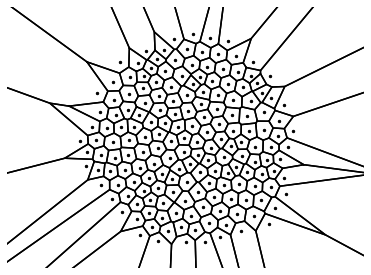

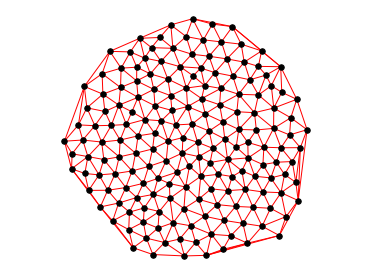

In [9]:
from Organoid2D import Organoid
import networkx as nx
from scipy.spatial import Delaunay
from scipy.spatial.distance import cdist
import numpy as np
import itertools
import matplotlib.pyplot as plt

org = Organoid()
org.evolution(T = 0.1, file = 'Organoid_mid.csv', mode = 'transcription')

Gr = nx.Graph()
dist = cdist(org.xy, org.xy)
tri = Delaunay(org.xy)

plt.figure(figsize = (6.4,4.8))
rr = org.r + org.r[:,None]
for nodes in tri.simplices:
    for path in list(itertools.combinations(nodes, 2)):
        if dist[path[0],path[1]] < rr[path[0],path[1]]:
        nx.add_path(Gr, path)
            
org.cellPlot()
plt.savefig('Results/Publications/Signal Range/Geometry.png', transparent=True)
plt.savefig('Results/Publications/Signal Range/Geometry.pdf', transparent=True)

plt.figure(figsize = (6.4,4.8))
plt.plot()
nx.draw(Gr, org.xy, node_size=30, edge_color='r', node_color='k')
plt.axis('equal')
plt.savefig('Results/Publications/Signal Range/CellGraph.png', transparent=True)
plt.savefig('Results/Publications/Signal Range/CellGraph.pdf', transparent=True)

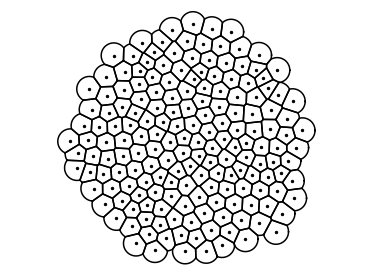

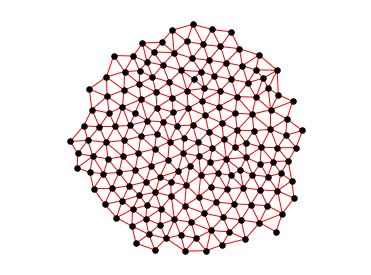

In [20]:
from Organoid2D import Organoid
import networkx as nx
from scipy.spatial import Delaunay
from scipy.spatial.distance import cdist
import numpy as np
import itertools
import matplotlib.pyplot as plt

org = Organoid()
org.evolution(T = 0.1, file = 'Organoid_mid.csv', mode = 'transcription')

Gr = nx.Graph()
dist = cdist(org.xy, org.xy)
tri = Delaunay(org.xy)

plt.figure(figsize = (6.4,4.8))
org.r = np.ones(org.nofCells)*1.1
rr = org.r + org.r[:,None]
for nodes in tri.simplices:
    for path in list(itertools.combinations(nodes, 2)):
        if dist[path[0],path[1]] < rr[path[0],path[1]]:
            nx.add_path(Gr, path)
            
org.cellPlot()
a = 1.15
plt.xlim([np.min(org.xy[:,0])*a, np.max(org.xy[:,0])*a])
plt.ylim([np.min(org.xy[:,1])*a, np.max(org.xy[:,1])*a])
plt.savefig('voronoi_cutoff.png', transparent=True)
plt.savefig('voronoi_cutoff.pdf', transparent=True)

plt.figure(figsize = (6.4,4.8))
plt.plot()
nx.draw(Gr, org.xy, node_size=30, edge_color='r', node_color='k')
plt.axis('equal')
plt.xlim([np.min(org.xy[:,0])*a, np.max(org.xy[:,0])*a])
plt.ylim([np.min(org.xy[:,1])*a, np.max(org.xy[:,1])*a])
plt.savefig('delaunay_cutoff.png', transparent=True)
plt.savefig('delaunay_cutoff.pdf', transparent=True)

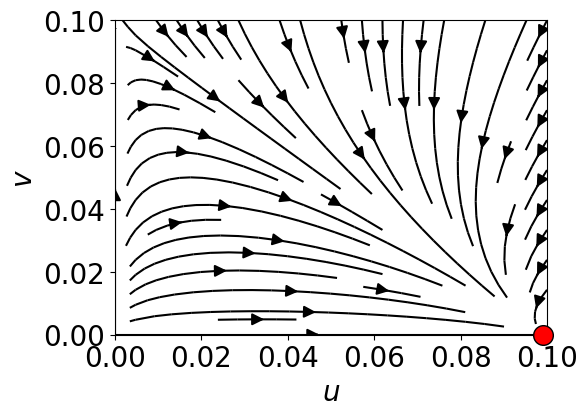

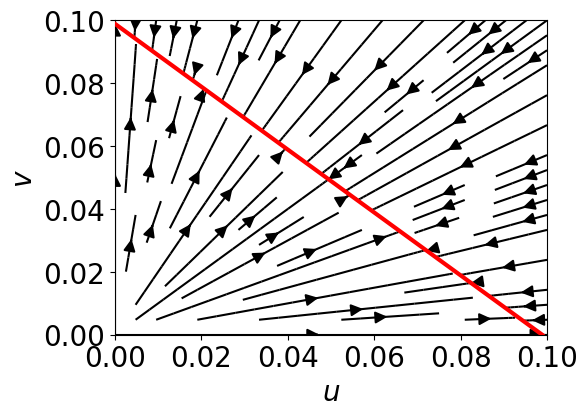

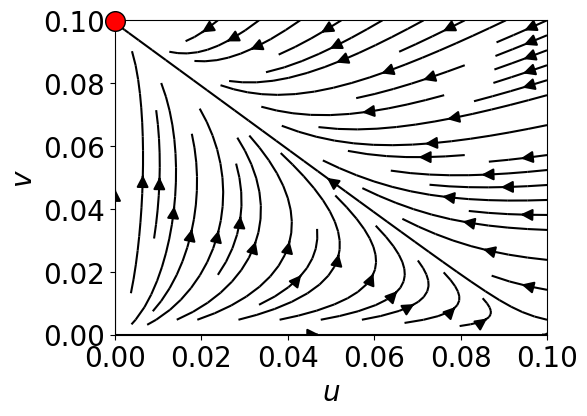

In [24]:
import numpy as np
import matplotlib.pyplot as plt

X, Y = np.meshgrid(np.linspace(0, .1, 50), np.linspace(0, .1, 50))
u, v = np.zeros_like(X), np.zeros_like(X)
NI, NJ = X.shape

η_g = np.exp(6)
η_n = np.exp(7)
η_s = np.exp(2)
η_gs = np.exp(2)
s = (η_n - η_g)/η_g/η_s/η_gs

def F(X, Y, s): 
    γ = 10
    r = 1
    
    U =        r*η_n*X        /(1 + η_g*Y*(1+η_s*η_gs*s) + η_n*X + η_s*s) - γ*X
    V = r*η_g*Y*(1+η_s*η_gs*s)/(1 + η_g*Y*(1+η_s*η_gs*s) + η_n*X + η_s*s) - γ*Y
    
    return U, V

U1, V1 = F(X,Y,0*s)
U2, V2 = F(X,Y,1*s)
U3, V3 = F(X,Y,2*s)

state1 = np.array([.1 - (1+η_s*0*s)/η_n, 0])
v_vals = np.linspace(0, .1 - (1+η_s*0*s)/η_n/(1+η_s*η_gs*s), 100)
state2 = .1 - (1+η_s*s)/η_n - v_vals
state3 = np.array([0, .1 - (1+η_s*0*s)/η_n/(1+η_s*η_gs*2*s)])

plt.rc('font', size=14*0.5/0.35)
plt.figure(figsize=[6.4, 4.8])
plt.gcf().subplots_adjust(left=0.15*3/2)
plt.gcf().subplots_adjust(bottom=0.15*3/2)
plt.streamplot(X, Y, U1, V1, density=.75, color='k', maxlength=100, arrowsize=1.75)
plt.xlabel('$u$')
plt.ylabel('$v$')
plt.axis([0, .1, 0, .1])
plt.xticks([0,0.02,0.04,0.06,0.08,0.1])
plt.yticks([0,0.02,0.04,0.06,0.08,0.1])
plt.scatter(state1[0], state1[1], s=200, color='r', edgecolors='k', zorder = 100, clip_on = False)
#plt.savefig('Results/Publications/Signal Range/Phase_s=0.png', transparent=True)
#plt.savefig('Results/Publications/Signal Range/Phase_s=0.pdf', transparent=True)
plt.savefig('Phase_s=0.png', transparent=True)
plt.savefig('Phase_s=0.pdf', transparent=True)

plt.figure(figsize=[6.4, 4.8])
plt.gcf().subplots_adjust(left=0.15*3/2)
plt.gcf().subplots_adjust(bottom=0.15*3/2)
plt.streamplot(X, Y, U2, V2, density=.75, color='k', maxlength=100, arrowsize=1.75)
plt.xlabel('$u$')
plt.ylabel('$v$')
plt.axis([0, .1, 0, .1])
plt.plot(state2, v_vals, color='r', lw=3, zorder = 100)
plt.xticks([0,0.02,0.04,0.06,0.08,0.1])
plt.yticks([0,0.02,0.04,0.06,0.08,0.1])
#plt.savefig('Results/Publications/Signal Range/Phase_s=1.png', transparent=True)
#plt.savefig('Results/Publications/Signal Range/Phase_s=1.pdf', transparent=True)
plt.savefig('Phase_s=1.png', transparent=True)
plt.savefig('Phase_s=1.pdf', transparent=True)

plt.figure(figsize=[6.4, 4.8])
plt.gcf().subplots_adjust(left=0.15*3/2)
plt.gcf().subplots_adjust(bottom=0.15*3/2)
plt.streamplot(X, Y, U3, V3, density=.75, color='k', maxlength=100, arrowsize=1.75)
plt.xlabel('$u$')
plt.ylabel('$v$')
plt.axis([0, .1, 0, .1])
plt.xticks([0,0.02,0.04,0.06,0.08,0.1])
plt.yticks([0,0.02,0.04,0.06,0.08,0.1])
plt.scatter(state3[0], state3[1], s=200, color='r', edgecolors='k', zorder = 100, clip_on = False)
#plt.savefig('Results/Publications/Signal Range/Phase_s=2.png', transparent=True)
#plt.savefig('Results/Publications/Signal Range/Phase_s=2.pdf', transparent=True)
plt.savefig('Phase_s=2.png', transparent=True)
plt.savefig('Phase_s=2.pdf', transparent=True)